In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
%matplotlib inline
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)
from wordcloud import WordCloud

### Getting Data
##### Getting Data From Csv's

In [2]:
cards_data = pd.read_csv('datasets/cards_data.csv')
users_data = pd.read_csv('datasets/users_data.csv')
users_data.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


##### Getting Data From Json's

In [3]:
with open('datasets/mcc_codes.json','r') as mcc_codes:
    data = json.load(mcc_codes)
with open('datasets/train_fraud_labels.json','r') as fraud_label:
    target = json.load(fraud_label)

In [4]:
mcc_codes = pd.DataFrame(list(data.items()), columns=['mcc', 'Description'])
fraud_label_target = pd.DataFrame(list(target.get('target').items()), columns=['transaction_id', 'fraud'])

##### Getting Data from Database

In [5]:
from db_connection import connect_to_db
connection = connect_to_db()
query = "SELECT * FROM transaction"
transaction_data = pd.read_sql(query, connection)

### IDA and Pre-processing

In [6]:
def get_data_card(df):
    print(f"Shape of given data is {df.shape}")
    print (f"\nCount of duplicate values is {df.duplicated().sum()}")
    print("\nNull Values ===> \n")
    print(df.isna().sum())
    print ("\nInformation about Data ===> \n")
    print(df.info())

##### Cards

In [7]:
cards_data.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [8]:
get_data_card(cards_data)

Shape of given data is (6146, 13)

Count of duplicate values is 0

Null Values ===> 

id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64

Information about Data ===> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6146 non-null   int64 
 1   client_id              6146 non-null   int64 
 2   card_brand             6146 non-null   object
 3   card_type              6146 non-null   object
 4   card_number            6146 non-null   int64 
 5   expires                6146 non-null   object
 6  

In [9]:
cards_data['credit_limit'] = cards_data['credit_limit'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)

In [10]:
cards_data.card_on_dark_web.value_counts()

card_on_dark_web
No    6146
Name: count, dtype: int64

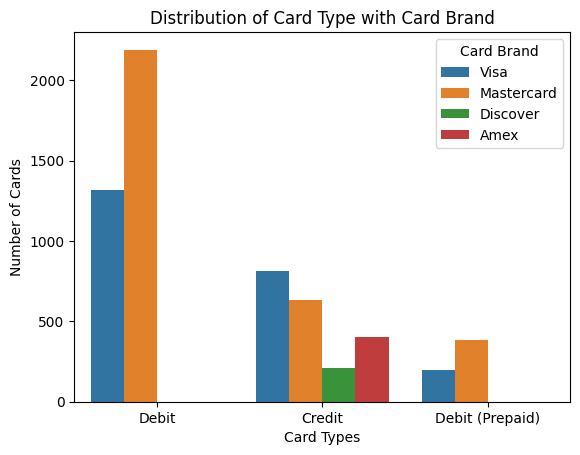

In [11]:
sns.countplot(x='card_type', hue='card_brand', data=cards_data)
plt.title("Distribution of Card Type with Card Brand")
plt.xlabel("Card Types")
plt.ylabel("Number of Cards")
plt.legend(title="Card Brand")
plt.show()

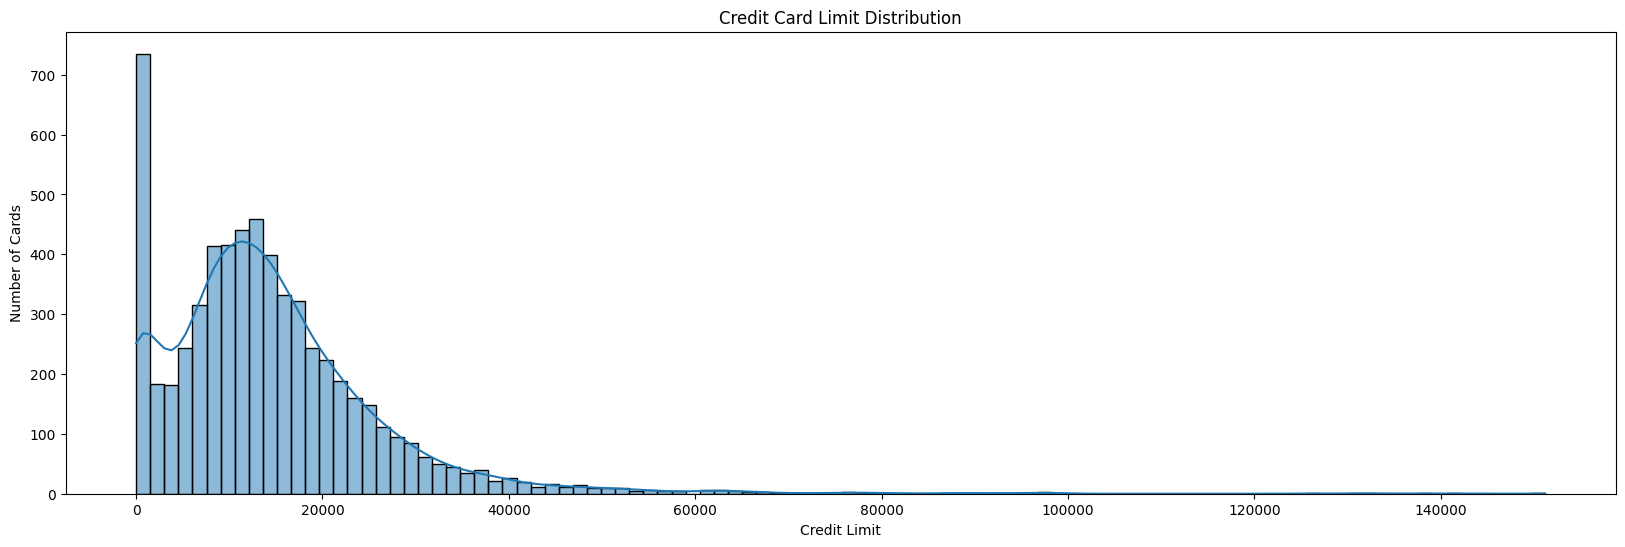

In [12]:
plt.figure(figsize=(20,6))
sns.histplot(data=cards_data, x='credit_limit', bins=100, kde=True)
plt.title("Credit Card Limit Distribution")
plt.xlabel("Credit Limit")
plt.ylabel("Number of Cards")
plt.show()

##### Users

In [13]:
users_data.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


In [14]:
get_data_card(users_data)

Shape of given data is (2000, 14)

Count of duplicate values is 0

Null Values ===> 

id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64

Information about Data ===> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   lati

In [15]:
users_data['per_capita_income'] = users_data['per_capita_income'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)
users_data['yearly_income'] = users_data['yearly_income'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)
users_data['total_debt'] = users_data['total_debt'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)

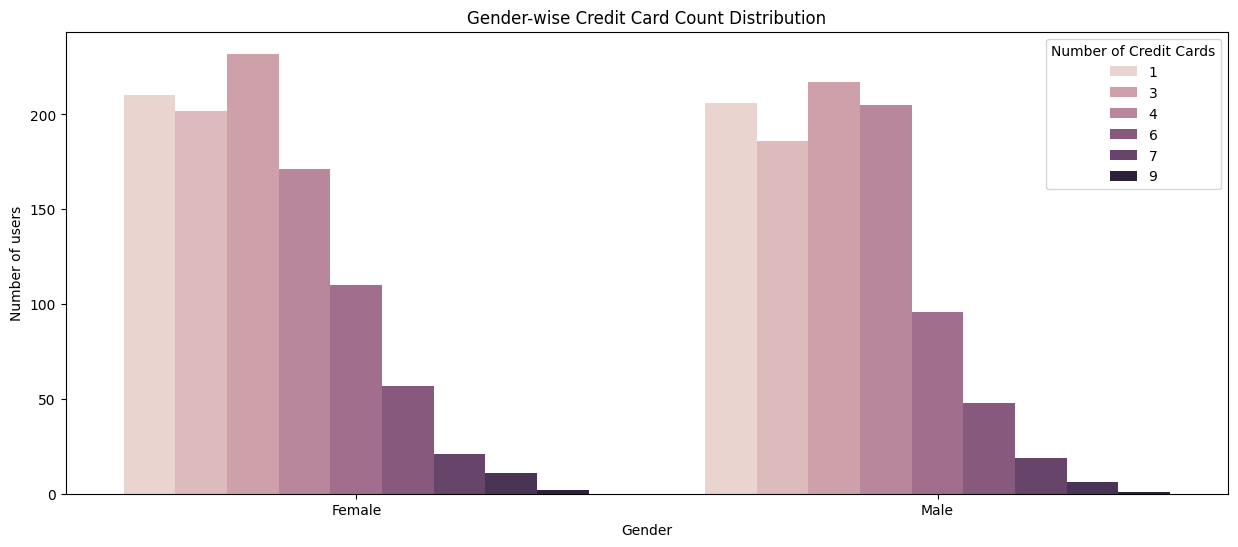

In [16]:
plt.figure(figsize=(15,6))
sns.countplot(x='gender', hue='num_credit_cards', data=users_data)
plt.title("Gender-wise Credit Card Count Distribution")
plt.xlabel("Gender")
plt.ylabel("Number of users")
plt.legend(title = "Number of Credit Cards")
plt.show()

##### MCC Codes

In [17]:
mcc_codes.head()

,mcc,Description
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees


In [18]:
get_data_card(mcc_codes)

Shape of given data is (109, 2)

Count of duplicate values is 0

Null Values ===> 

mcc            0
Description    0
dtype: int64

Information about Data ===> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   mcc          109 non-null    object
 1   Description  109 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB
None


In [19]:
mcc_codes.mcc  = mcc_codes.mcc.astype(int)

##### Fraud Labels

In [20]:
fraud_label_target.head()

,transaction_id,fraud
0,10649266,No
1,23410063,No
2,9316588,No
3,12478022,No
4,9558530,No


In [21]:
get_data_card(fraud_label_target)

Shape of given data is (8914963, 2)

Count of duplicate values is 0

Null Values ===> 

transaction_id    0
fraud             0
dtype: int64

Information about Data ===> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   transaction_id  object
 1   fraud           object
dtypes: object(2)
memory usage: 136.0+ MB
None


In [22]:
fraud_label_target.transaction_id  = fraud_label_target.transaction_id.astype(int)
fraud_label_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   transaction_id  int64 
 1   fraud           object
dtypes: int64(1), object(1)
memory usage: 136.0+ MB


In [23]:
fraud_label_target.fraud.value_counts()

fraud
No     8901631
Yes      13332
Name: count, dtype: int64

##### Transaction Data

In [24]:
transaction_data.head()

,id,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None


In [25]:
get_data_card(transaction_data)

Shape of given data is (13305915, 12)

Count of duplicate values is 0

Null Values ===> 

id                         0
date                       0
client_id                  0
card_id                    0
amount                     0
transaction_mode           0
merchant_id                0
merchant_city              0
merchant_state       1563700
zip                  1652706
mcc                        0
error               13094522
dtype: int64

Information about Data ===> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                int64  
 1   date              object 
 2   client_id         int64  
 3   card_id           int64  
 4   amount            float64
 5   transaction_mode  object 
 6   merchant_id       int64  
 7   merchant_city     object 
 8   merchant_state    object 
 9   zip               object 
 10  mcc               int64  


In [26]:
transaction_data[transaction_data.merchant_state.isna()].transaction_mode.value_counts()
#All the transaction where merchant state is null are online Transactions

transaction_mode
Online Transaction    1557912
Chip Transaction         5788
Name: count, dtype: int64

In [27]:
transaction_data.date = pd.to_datetime(transaction_data.date)
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                int64         
 1   date              datetime64[ns]
 2   client_id         int64         
 3   card_id           int64         
 4   amount            float64       
 5   transaction_mode  object        
 6   merchant_id       int64         
 7   merchant_city     object        
 8   merchant_state    object        
 9   zip               object        
 10  mcc               int64         
 11  error             object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 1.2+ GB


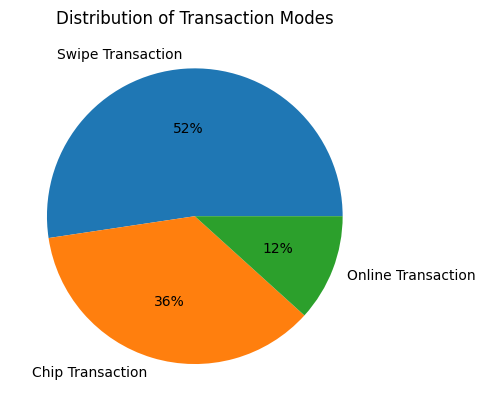

In [28]:
labels = transaction_data.transaction_mode.value_counts().index.tolist()
data = transaction_data.transaction_mode.value_counts().values
palette_color = sns.color_palette('tab10')
plt.pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
plt.title("Distribution of Transaction Modes")
# displaying chart
plt.show()

### Merging DataFrames

In [29]:
transaction_fraud = transaction_data.merge(fraud_label_target,how='left',left_on='id', right_on='transaction_id')
transaction_fraud.drop('id',inplace=True,axis =1)

In [30]:
transaction_fraud_card = transaction_fraud.merge(cards_data[['id','card_brand','card_type','expires','has_chip','num_cards_issued','credit_limit','acct_open_date','year_pin_last_changed']],how='left',left_on='card_id', right_on='id')
transaction_fraud_card.drop('id',inplace=True,axis =1)

In [31]:
transaction_fraud_card_users = transaction_fraud_card.merge(users_data[['id','current_age','retirement_age','birth_year','birth_month','gender','per_capita_income','yearly_income','total_debt','credit_score','num_credit_cards']],how='left',left_on='client_id', right_on='id')
transaction_fraud_card_users.drop('id',inplace=True,axis =1)

In [32]:
main_df =  transaction_fraud_card_users.merge(mcc_codes,how='left',left_on='mcc',right_on='mcc')
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,7475327.0,No,Mastercard,Debit (Prepaid),07/2022,YES,2,55.0,05/2008,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,7475328.0,No,Mastercard,Credit,12/2024,YES,1,9100.0,09/2005,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,7475329.0,No,Mastercard,Debit,05/2020,YES,1,14802.0,01/2006,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None,NaN,NaN,Mastercard,Debit,10/2024,NO,2,37634.0,05/2004,2006,52,67,1967,5,Female,26168.0,53350.0,128676.0,685,5,Money Transfer
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,7475332.0,No,Visa,Debit,01/2020,YES,1,19113.0,07/2009,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages)


In [33]:
main_df.fraud.isna().sum()

np.int64(4390952)

In [34]:
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,7475327.0,No,Mastercard,Debit (Prepaid),07/2022,YES,2,55.0,05/2008,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,7475328.0,No,Mastercard,Credit,12/2024,YES,1,9100.0,09/2005,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,7475329.0,No,Mastercard,Debit,05/2020,YES,1,14802.0,01/2006,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None,NaN,NaN,Mastercard,Debit,10/2024,NO,2,37634.0,05/2004,2006,52,67,1967,5,Female,26168.0,53350.0,128676.0,685,5,Money Transfer
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,7475332.0,No,Visa,Debit,01/2020,YES,1,19113.0,07/2009,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages)


In [35]:
main_df['year'] = pd.to_datetime(main_df['date']).dt.year
main_df['month'] = pd.to_datetime(main_df['date']).dt.month

In [36]:
# Splitting Test and Final dataframe based on fraud values avaliable (Fraud = NA, will be used in Test)
test_df = main_df[main_df.fraud.isna()]
final_df = main_df[main_df.fraud.notna()]

### Fraud Transaction Analysis

In [37]:
transaction_fraud_yes = final_df[final_df.fraud=='Yes']
final_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description,year,month
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,7475327.0,No,Mastercard,Debit (Prepaid),07/2022,YES,2,55.0,05/2008,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores,2010,1
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,7475328.0,No,Mastercard,Credit,12/2024,YES,1,9100.0,09/2005,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores,2010,1
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,7475329.0,No,Mastercard,Debit,05/2020,YES,1,14802.0,01/2006,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer,2010,1
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,7475332.0,No,Visa,Debit,01/2020,YES,1,19113.0,07/2009,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages),2010,1
5,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464,5942,None,7475333.0,No,Mastercard,Debit (Prepaid),03/2014,YES,1,89.0,01/2008,2015,47,65,1972,12,Female,25537.0,52065.0,98613.0,828,5,Book Stores,2010,1


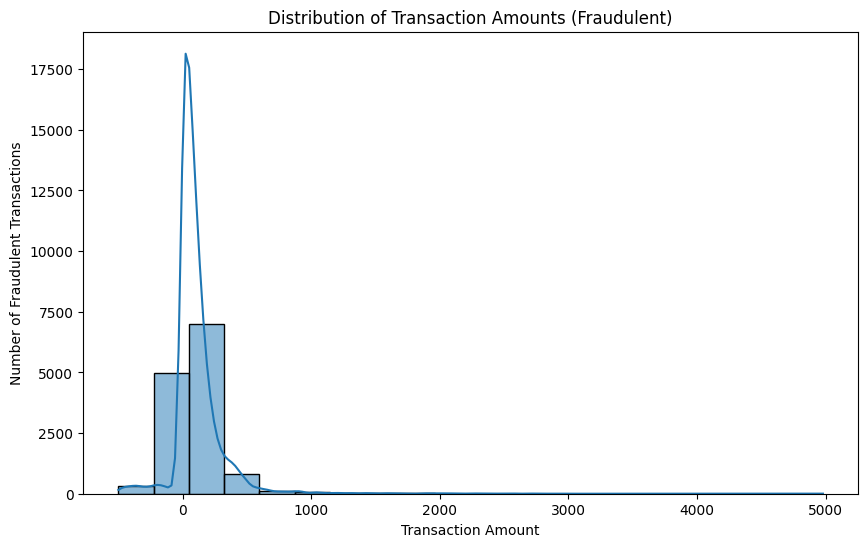

In [38]:
plt.figure(figsize=(10,6))
sns.histplot(data=transaction_fraud_yes, x='amount', bins=20, kde=True)
plt.title("Distribution of Transaction Amounts (Fraudulent)")
plt.xlabel("Transaction Amount")
plt.ylabel("Number of Fraudulent Transactions")
plt.show()

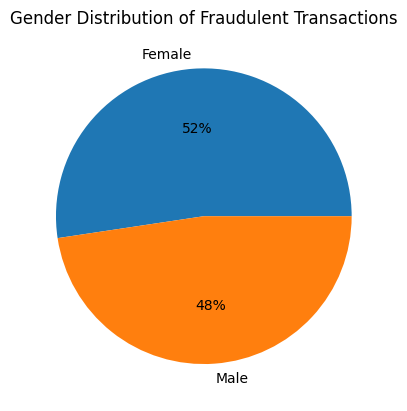

In [39]:
labels = transaction_fraud_yes.gender.value_counts().index.tolist()
data = transaction_fraud_yes.gender.value_counts().values
palette_color = sns.color_palette('tab10')
plt.pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
plt.title('Gender Distribution of Fraudulent Transactions')
# displaying chart
plt.show()

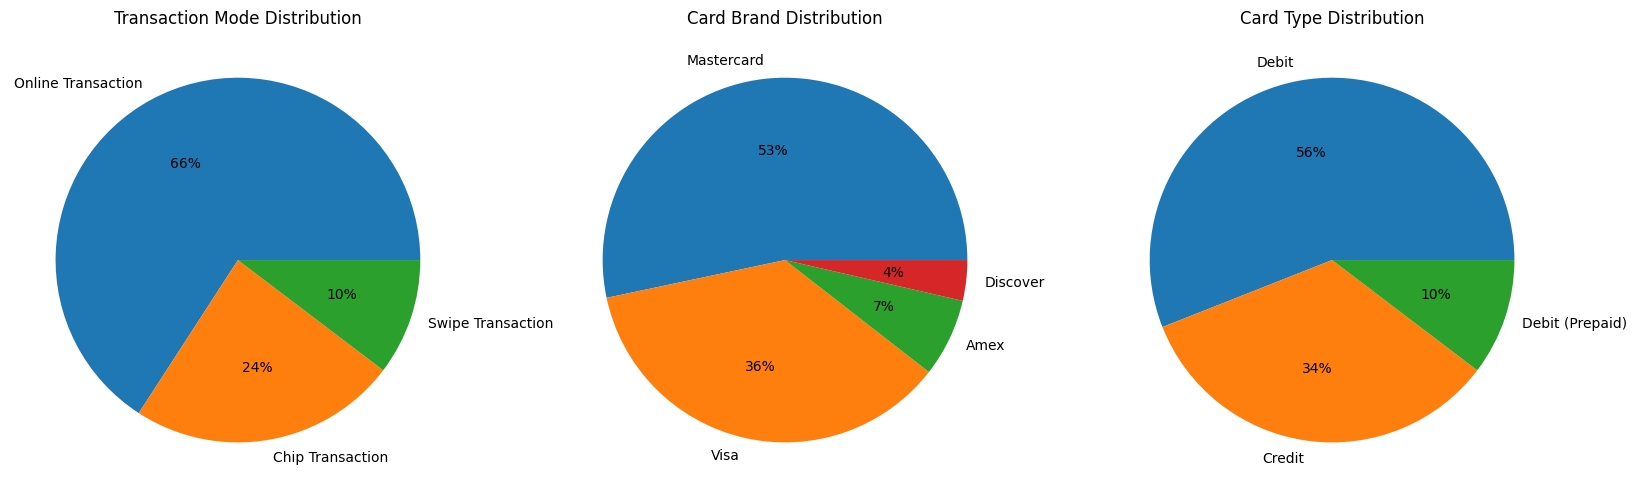

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

labels = transaction_fraud_yes.transaction_mode.value_counts().index.tolist()
data = transaction_fraud_yes.transaction_mode.value_counts().values
palette_color = sns.color_palette('tab10')
ax[0].pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
ax[0].set_title('Transaction Mode Distribution')


labels = transaction_fraud_yes.card_brand.value_counts().index.tolist()
data = transaction_fraud_yes.card_brand.value_counts().values
ax[1].pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
ax[1].set_title('Card Brand Distribution')


labels = transaction_fraud_yes.card_type.value_counts().index.tolist()
data = transaction_fraud_yes.card_type.value_counts().values
ax[2].pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
ax[2].set_title('Card Type Distribution')

plt.show()


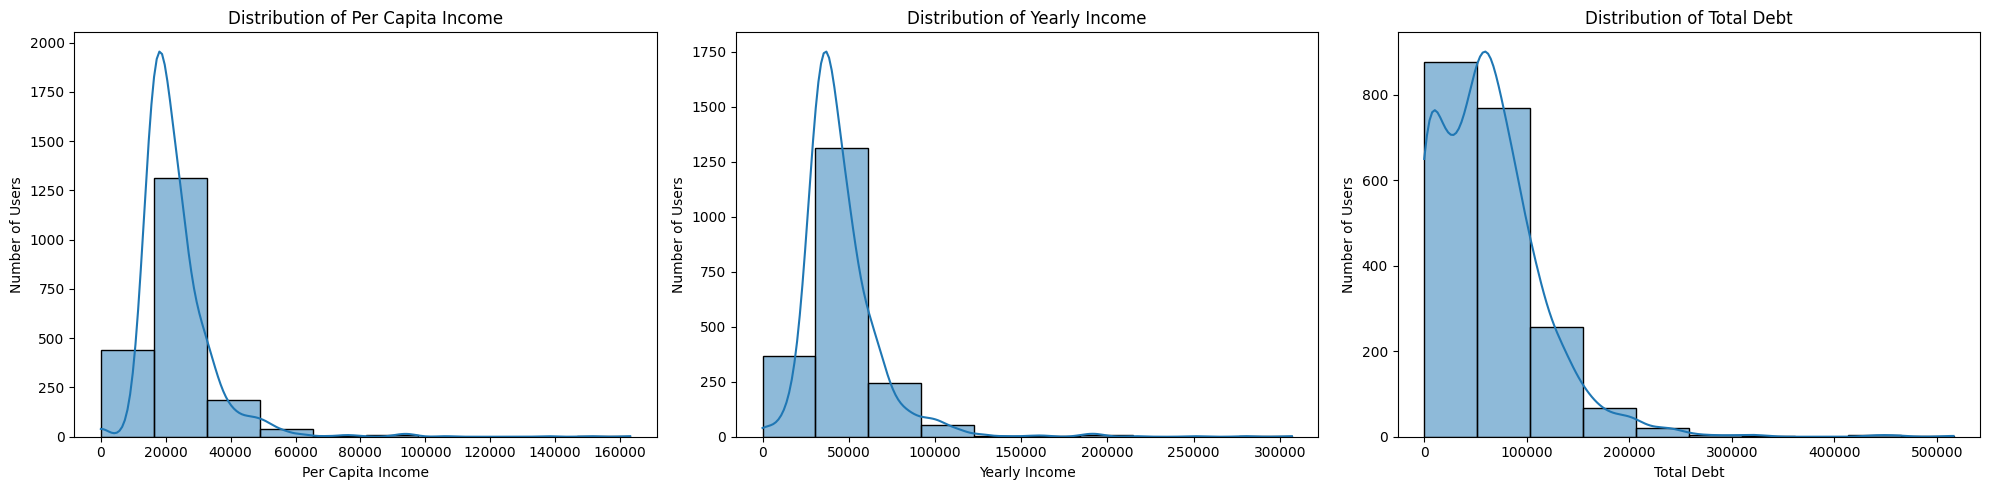

In [41]:
fig, ax = plt.subplots(1,3, figsize = (20,5))

sns.histplot(data=users_data, x='per_capita_income', bins=10, kde=True,ax=ax[0])
ax[0].set_title("Distribution of Per Capita Income")
ax[0].set_xlabel("Per Capita Income")
ax[0].set_ylabel("Number of Users")

sns.histplot(data=users_data, x='yearly_income', bins=10, kde=True,ax=ax[1])
ax[1].set_title("Distribution of Yearly Income")
ax[1].set_xlabel("Yearly Income")
ax[1].set_ylabel("Number of Users")

sns.histplot(data=users_data, x='total_debt', bins=10, kde=True,ax=ax[2])
ax[2].set_title("Distribution of Total Debt")
ax[2].set_xlabel("Total Debt")
ax[2].set_ylabel("Number of Users")

plt.tight_layout()
plt.show()

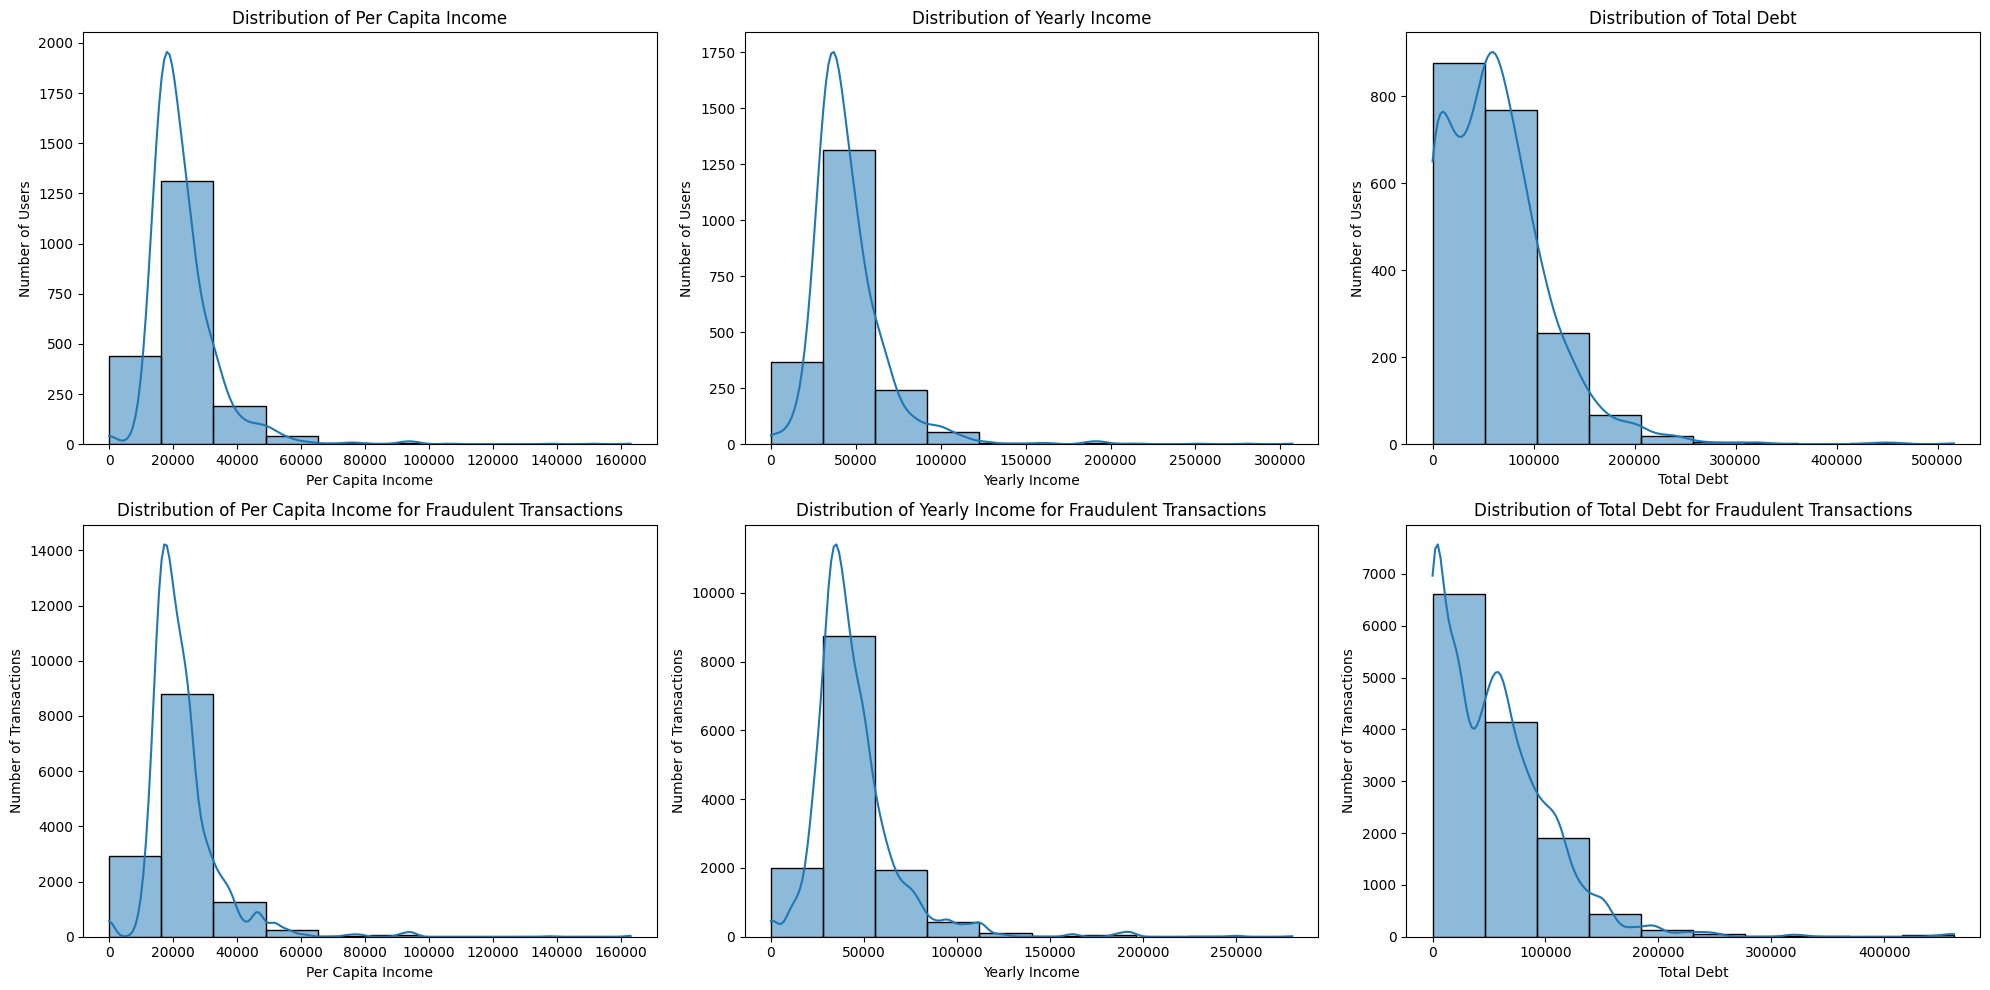

In [42]:
fig, ax = plt.subplots(2,3, figsize = (20,10))

sns.histplot(data=users_data, x='per_capita_income', bins=10, kde=True,ax=ax[0,0])
ax[0,0].set_title("Distribution of Per Capita Income")
ax[0,0].set_xlabel("Per Capita Income")
ax[0,0].set_ylabel("Number of Users")

sns.histplot(data=users_data, x='yearly_income', bins=10, kde=True,ax=ax[0,1])
ax[0,1].set_title("Distribution of Yearly Income")
ax[0,1].set_xlabel("Yearly Income")
ax[0,1].set_ylabel("Number of Users")

sns.histplot(data=users_data, x='total_debt', bins=10, kde=True,ax=ax[0,2])
ax[0,2].set_title("Distribution of Total Debt")
ax[0,2].set_xlabel("Total Debt")
ax[0,2].set_ylabel("Number of Users")

sns.histplot(data=transaction_fraud_yes, x='per_capita_income', bins=10, kde=True,ax=ax[1,0])
ax[1,0].set_title("Distribution of Per Capita Income for Fraudulent Transactions")
ax[1,0].set_xlabel("Per Capita Income")
ax[1,0].set_ylabel("Number of Transactions")

sns.histplot(data=transaction_fraud_yes, x='yearly_income', bins=10, kde=True,ax=ax[1,1])
ax[1,1].set_title("Distribution of Yearly Income for Fraudulent Transactions")
ax[1,1].set_xlabel("Yearly Income")
ax[1,1].set_ylabel("Number of Transactions")

sns.histplot(data=transaction_fraud_yes, x='total_debt', bins=10, kde=True,ax=ax[1,2])
ax[1,2].set_title("Distribution of Total Debt for Fraudulent Transactions")
ax[1,2].set_xlabel("Total Debt")
ax[1,2].set_ylabel("Number of Transactions")

plt.tight_layout()
plt.show()

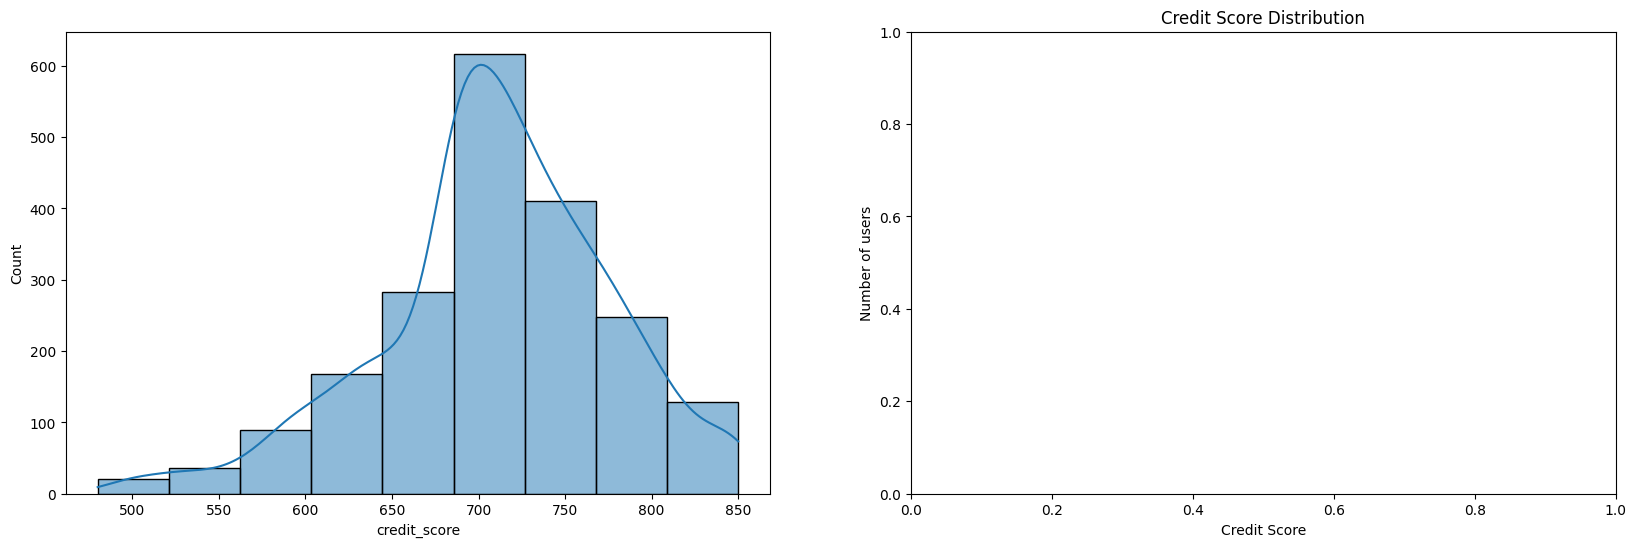

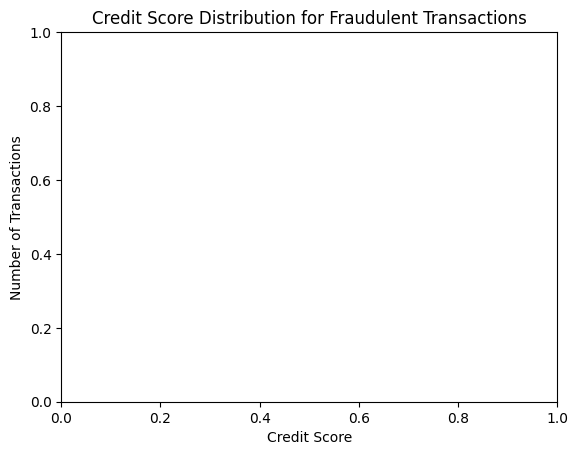

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.histplot(data=users_data, x='credit_score', bins=9, kde=True,ax=ax[0])
plt.title("Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Number of users")
plt.show()

sns.histplot(data=transaction_fraud_yes, x='credit_score', bins=9, kde=True,ax=ax[1])
plt.title("Credit Score Distribution for Fraudulent Transactions")
plt.xlabel("Credit Score")
plt.ylabel("Number of Transactions")
plt.show()

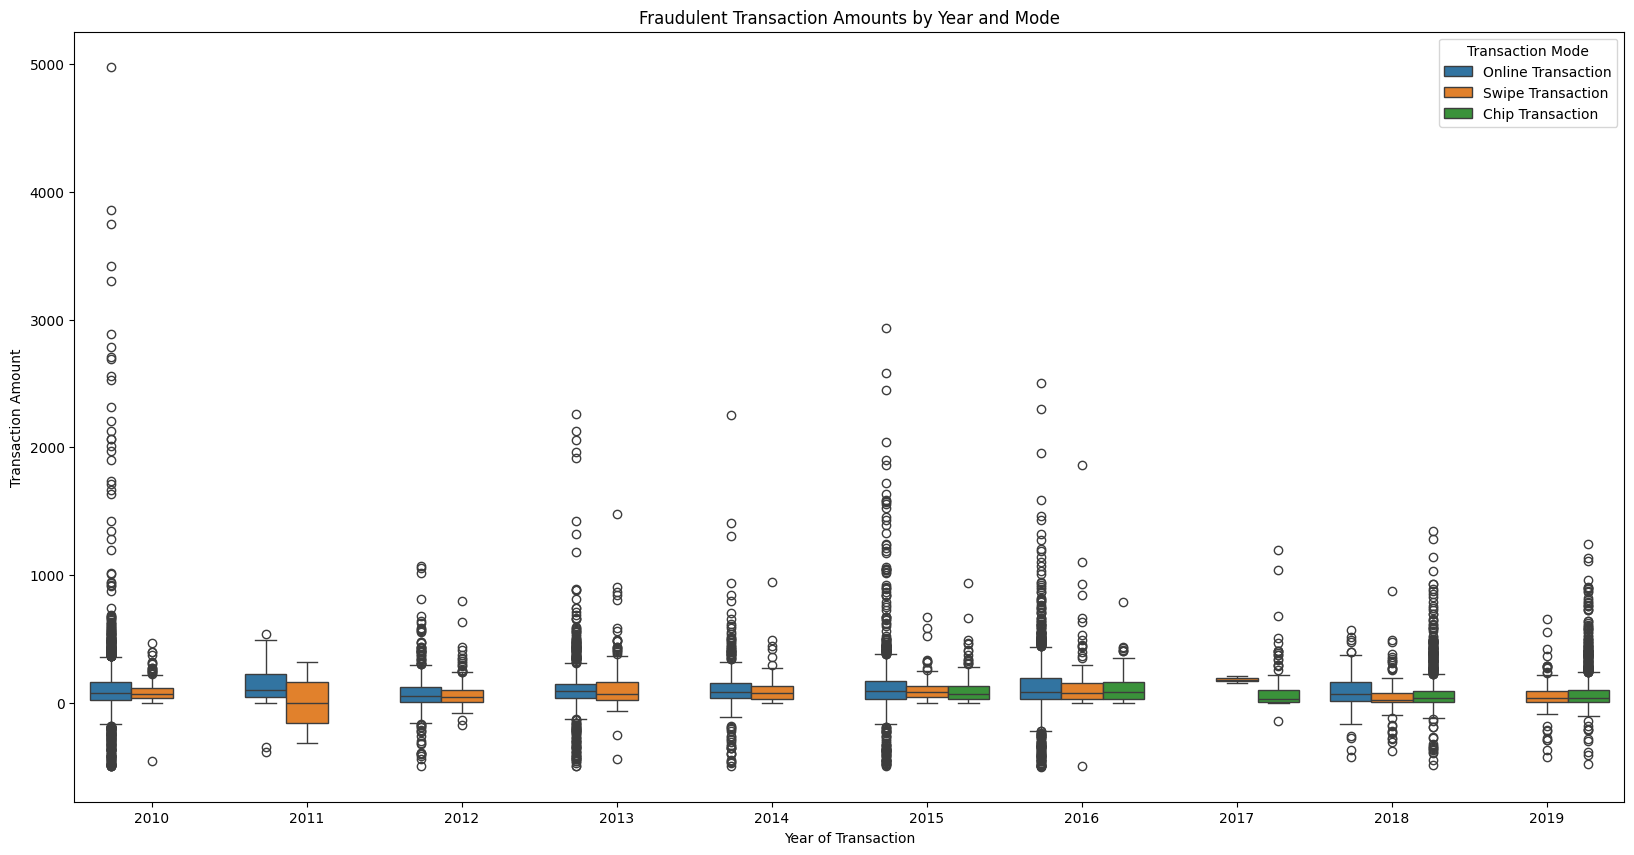

In [44]:
plt.figure(figsize=(20,10))
sns.boxplot(data=transaction_fraud_yes, x="year", y="amount", hue="transaction_mode")
plt.title("Fraudulent Transaction Amounts by Year and Mode")
plt.xlabel("Year of Transaction")
plt.ylabel("Transaction Amount")
plt.legend(title="Transaction Mode")
plt.show()

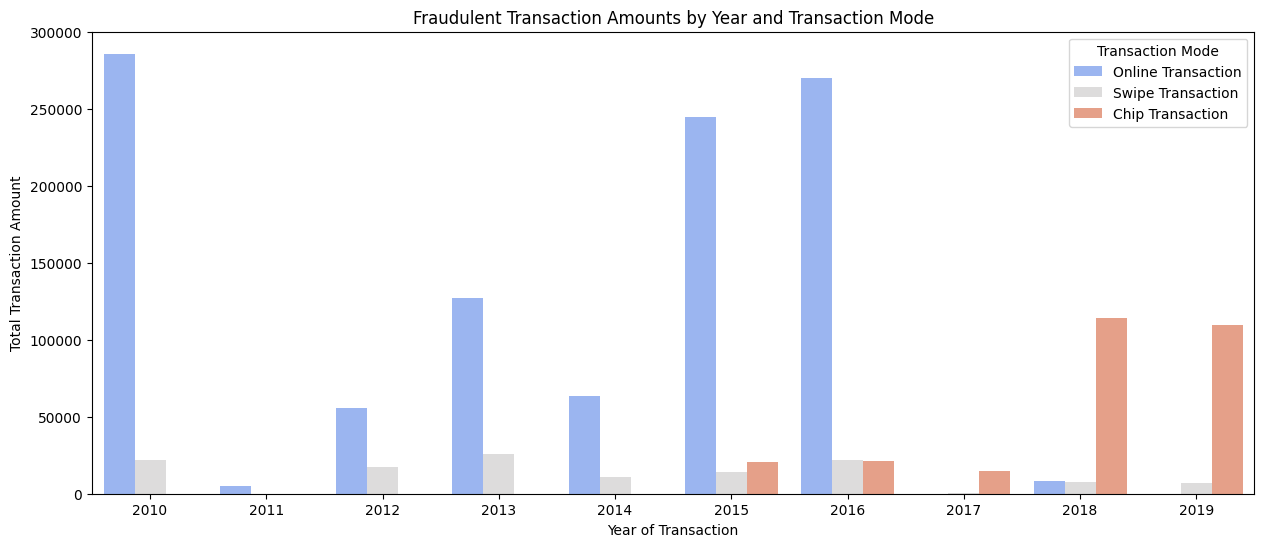

In [45]:
transaction_fraud_yes_grp_year_mode = transaction_fraud_yes.groupby(['transaction_mode','year'])['amount'].agg(
    mean_amount='mean',
    max_amount='max',
    min_amount='min',
    total_amount='sum',
    count = 'count'
)

transaction_fraud_yes_grp_year_mode = transaction_fraud_yes_grp_year_mode.reset_index()

plt.subplots( figsize = (15,6))
sns.barplot(x="year", y="total_amount", palette="coolwarm", hue = 'transaction_mode', data =transaction_fraud_yes_grp_year_mode)
plt.title("Fraudulent Transaction Amounts by Year and Transaction Mode")
plt.xlabel("Year of Transaction")
plt.ylabel("Total Transaction Amount")
plt.legend(title="Transaction Mode")
plt.show()

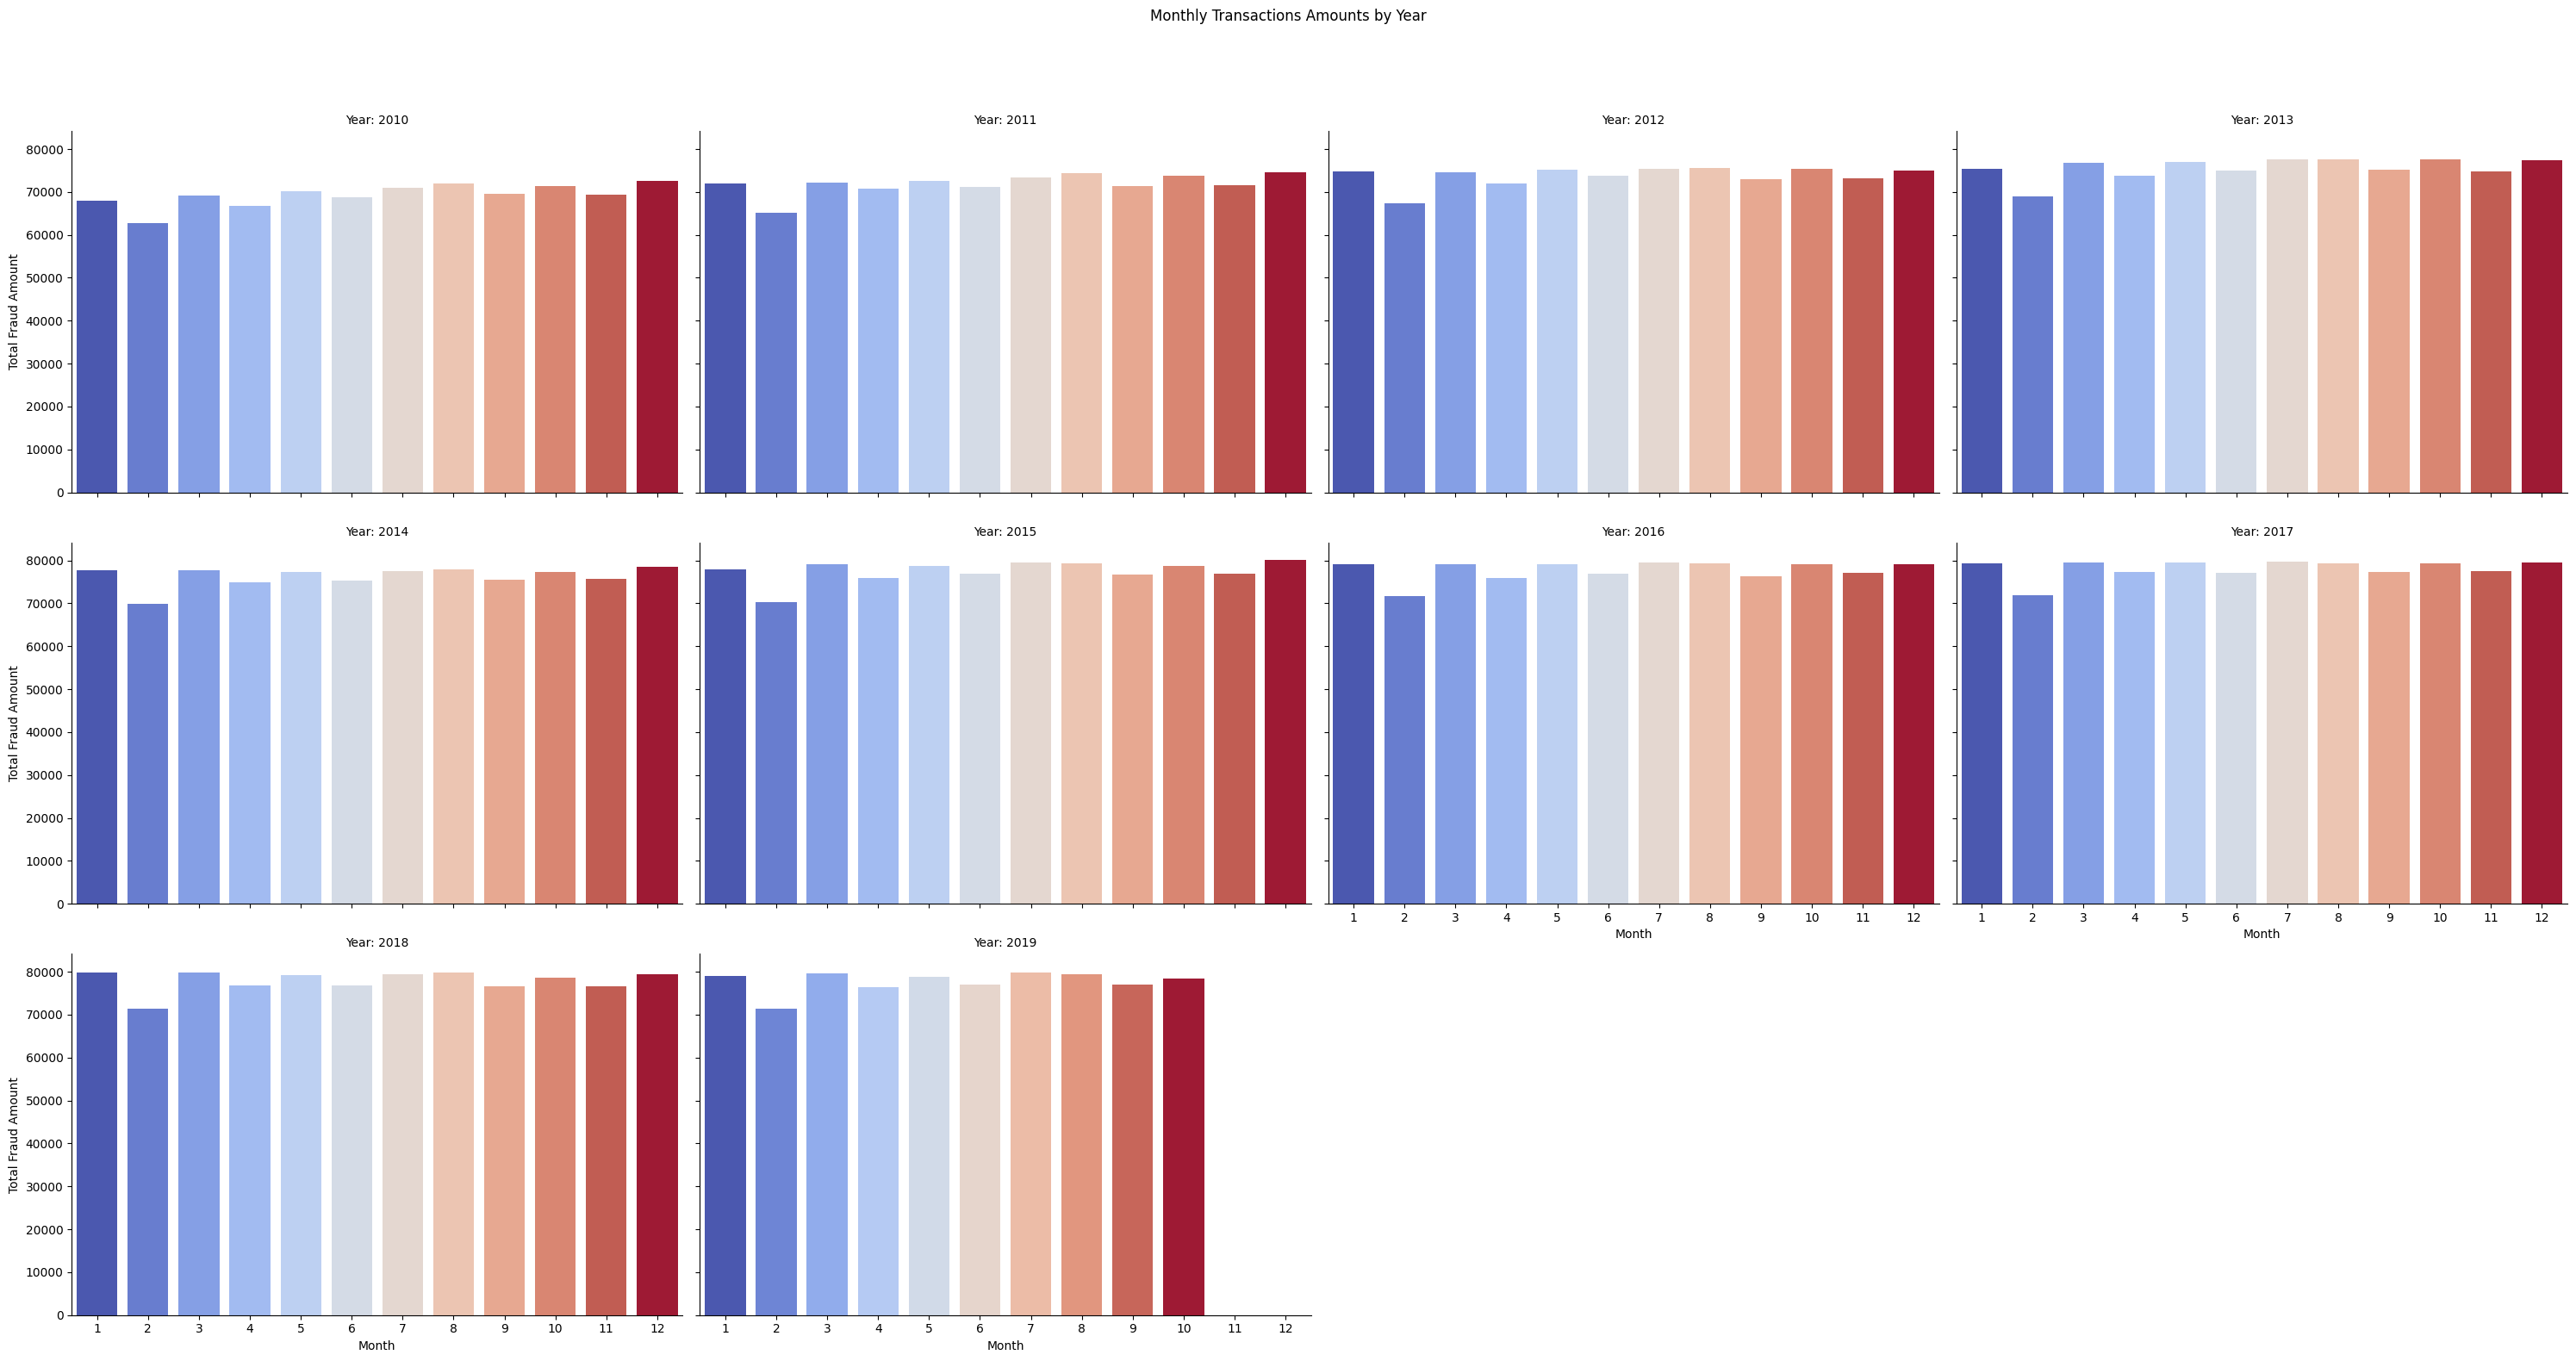

In [46]:
final_df_grp_year_month = final_df.groupby(['month','year'])['amount'].agg(
    mean_amount='mean',
    max_amount='max',
    min_amount='min',
    total_amount='sum',
    count = 'count'
)

final_df_grp_year_month = final_df_grp_year_month.reset_index()

g = sns.FacetGrid(final_df_grp_year_month, col="year", col_wrap=4, height=5, aspect=1.5)
g.map_dataframe(sns.barplot, x="month", y="count", palette="coolwarm", hue = 'month')
g.set_titles("Year: {col_name}")
g.set_axis_labels("Month", "Total Fraud Amount")
g.fig.suptitle("Monthly Transactions Amounts by Year", y=1.05)
plt.tight_layout()
plt.show()

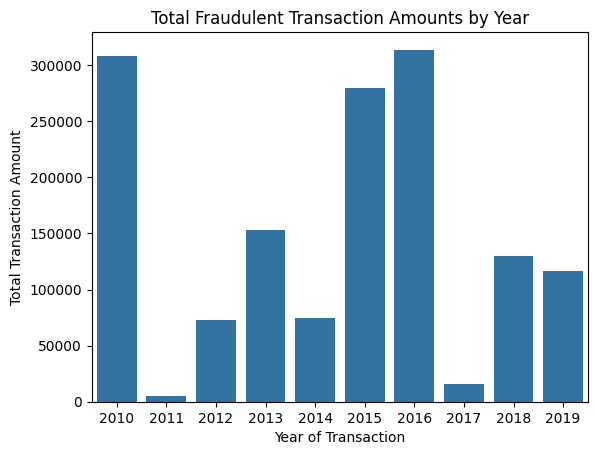

In [47]:
transaction_fraud_yes_grp_year= transaction_fraud_yes.groupby(['year'])['amount'].agg(
    mean_amount='mean',
    max_amount='max',
    min_amount='min',
    total_amount='sum',
    count = 'count')

sns.barplot(x='year',y='total_amount',data = transaction_fraud_yes_grp_year)
plt.title("Total Fraudulent Transaction Amounts by Year")
plt.xlabel("Year of Transaction")
plt.ylabel("Total Transaction Amount")
plt.show()

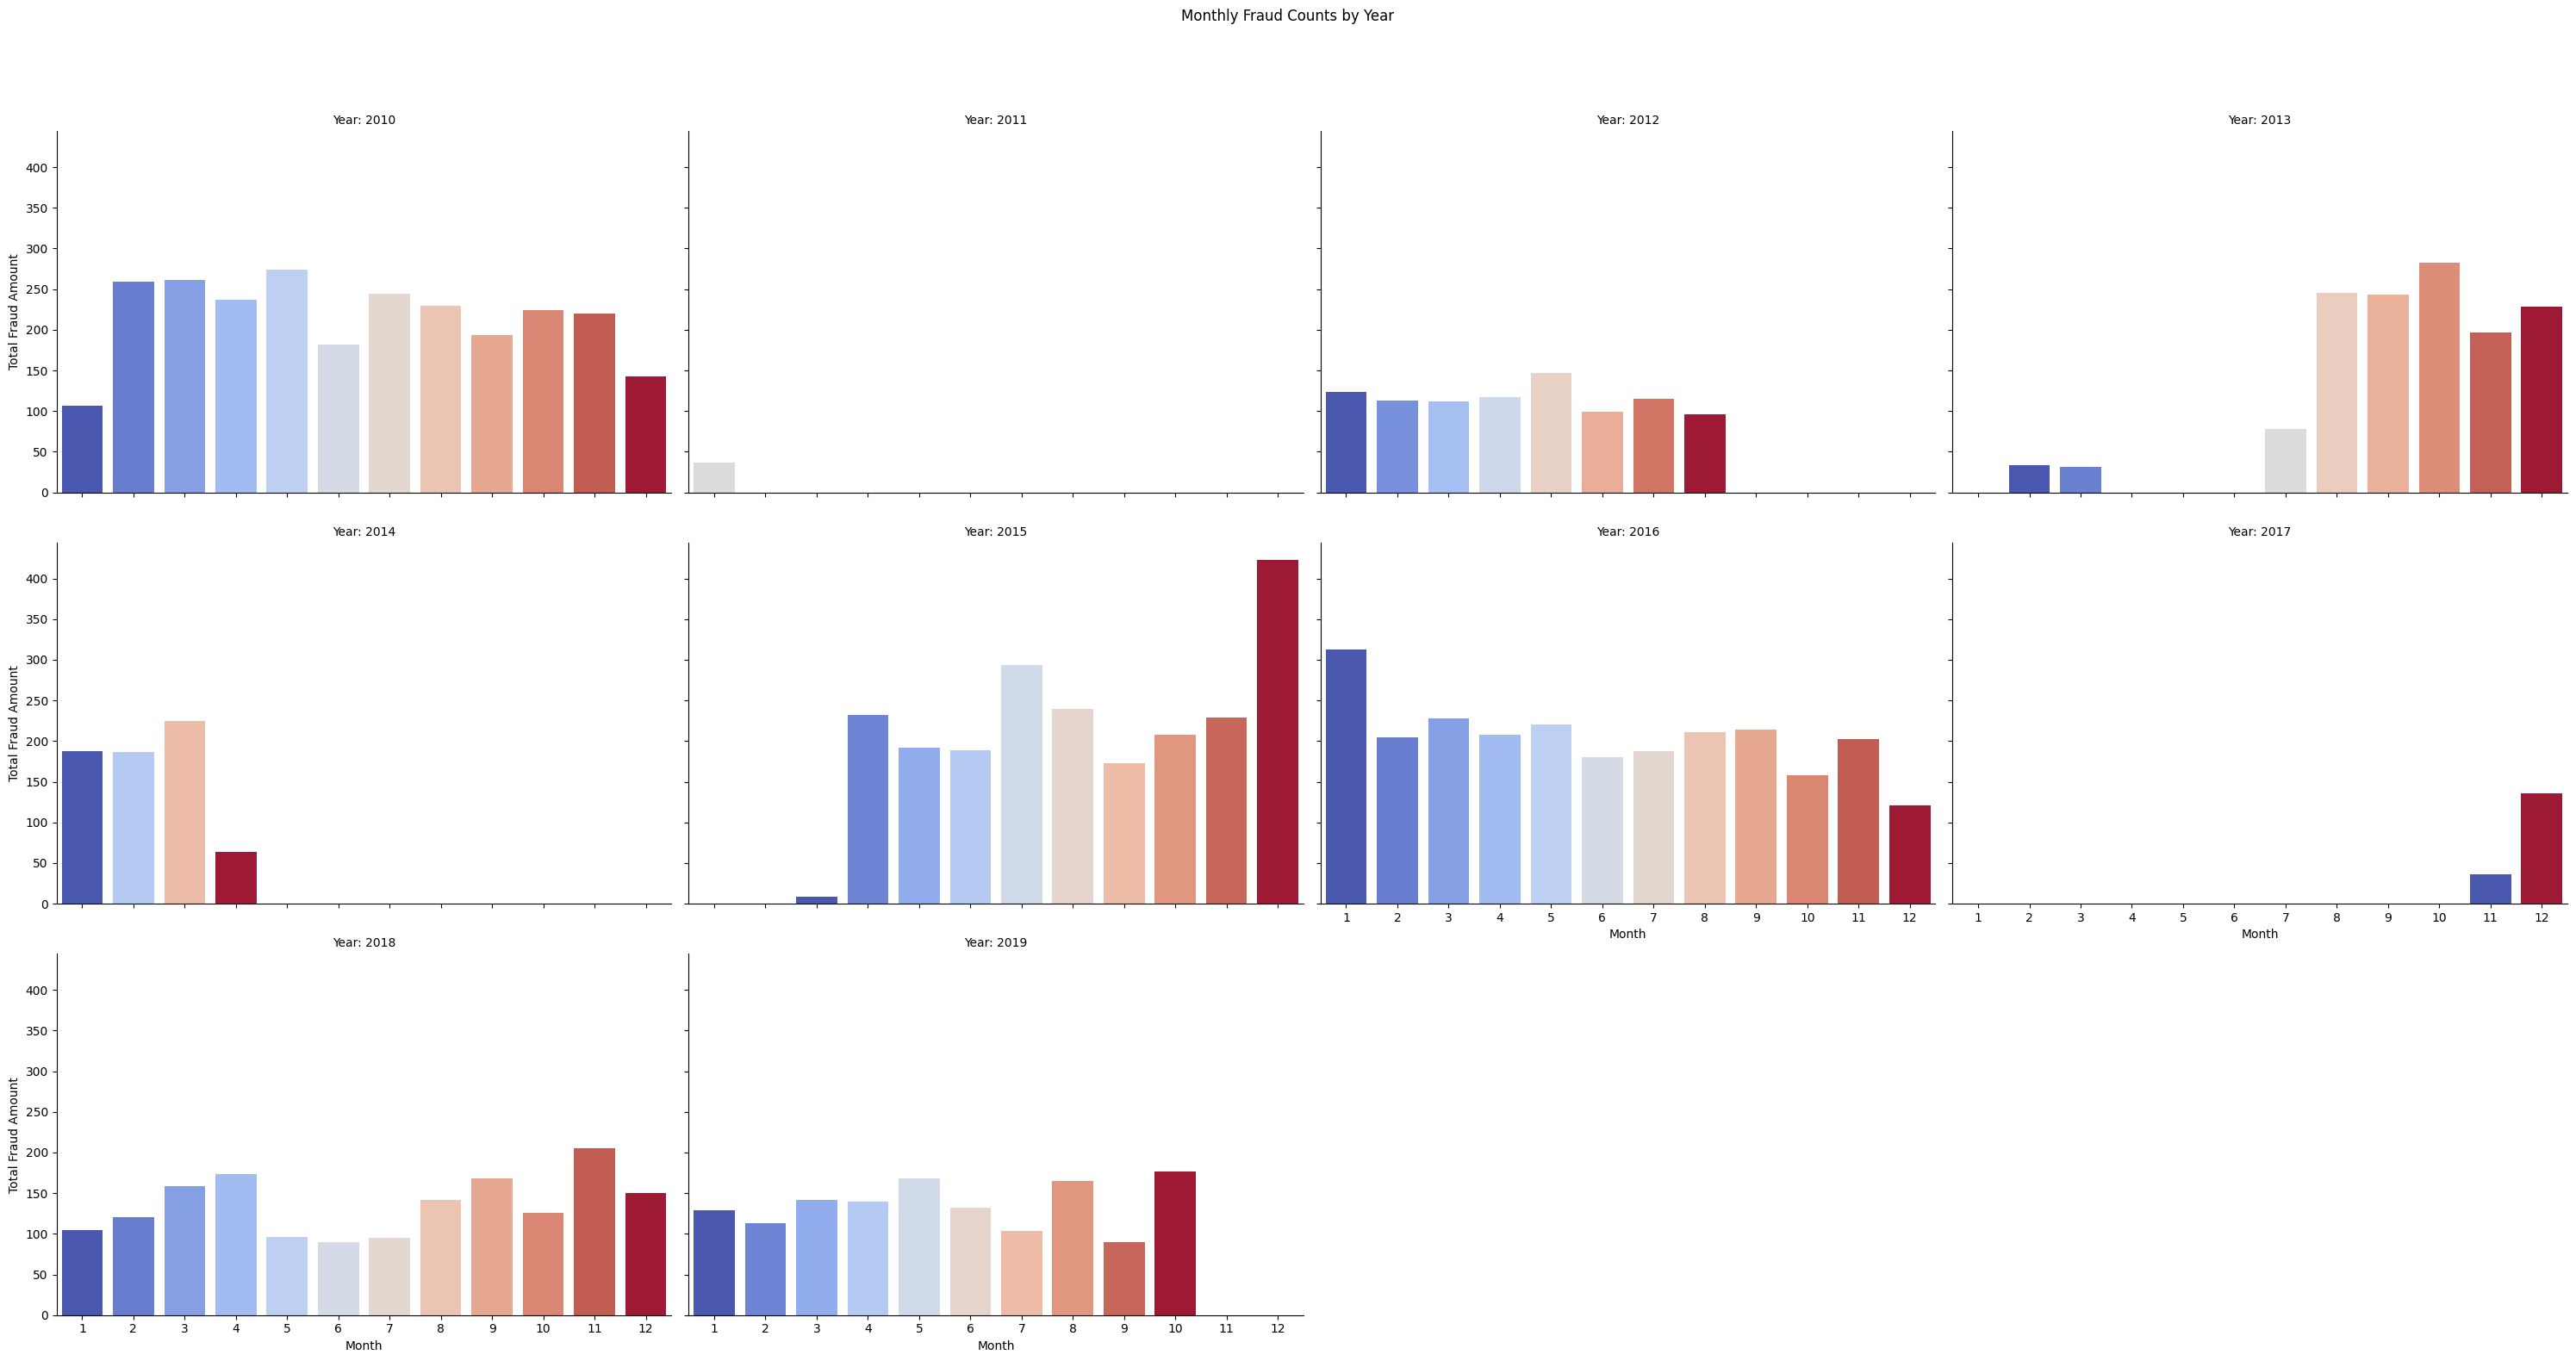

In [48]:
transaction_fraud_yes_grp_year_month = transaction_fraud_yes.groupby(['month','year'])['amount'].agg(
    mean_amount='mean',
    max_amount='max',
    min_amount='min',
    total_amount='sum',
    count = 'count'
)

transaction_fraud_yes_grp_year_month = transaction_fraud_yes_grp_year_month.reset_index()

g = sns.FacetGrid(transaction_fraud_yes_grp_year_month, col="year", col_wrap=4, height=5, aspect=1.5)
g.map_dataframe(sns.barplot, x="month", y="count", palette="coolwarm", hue = 'month')
g.set_titles("Year: {col_name}")
g.set_axis_labels("Month", "Total Fraud Amount")
g.fig.suptitle("Monthly Fraud Counts by Year", y=1.05)
plt.tight_layout()
plt.show()

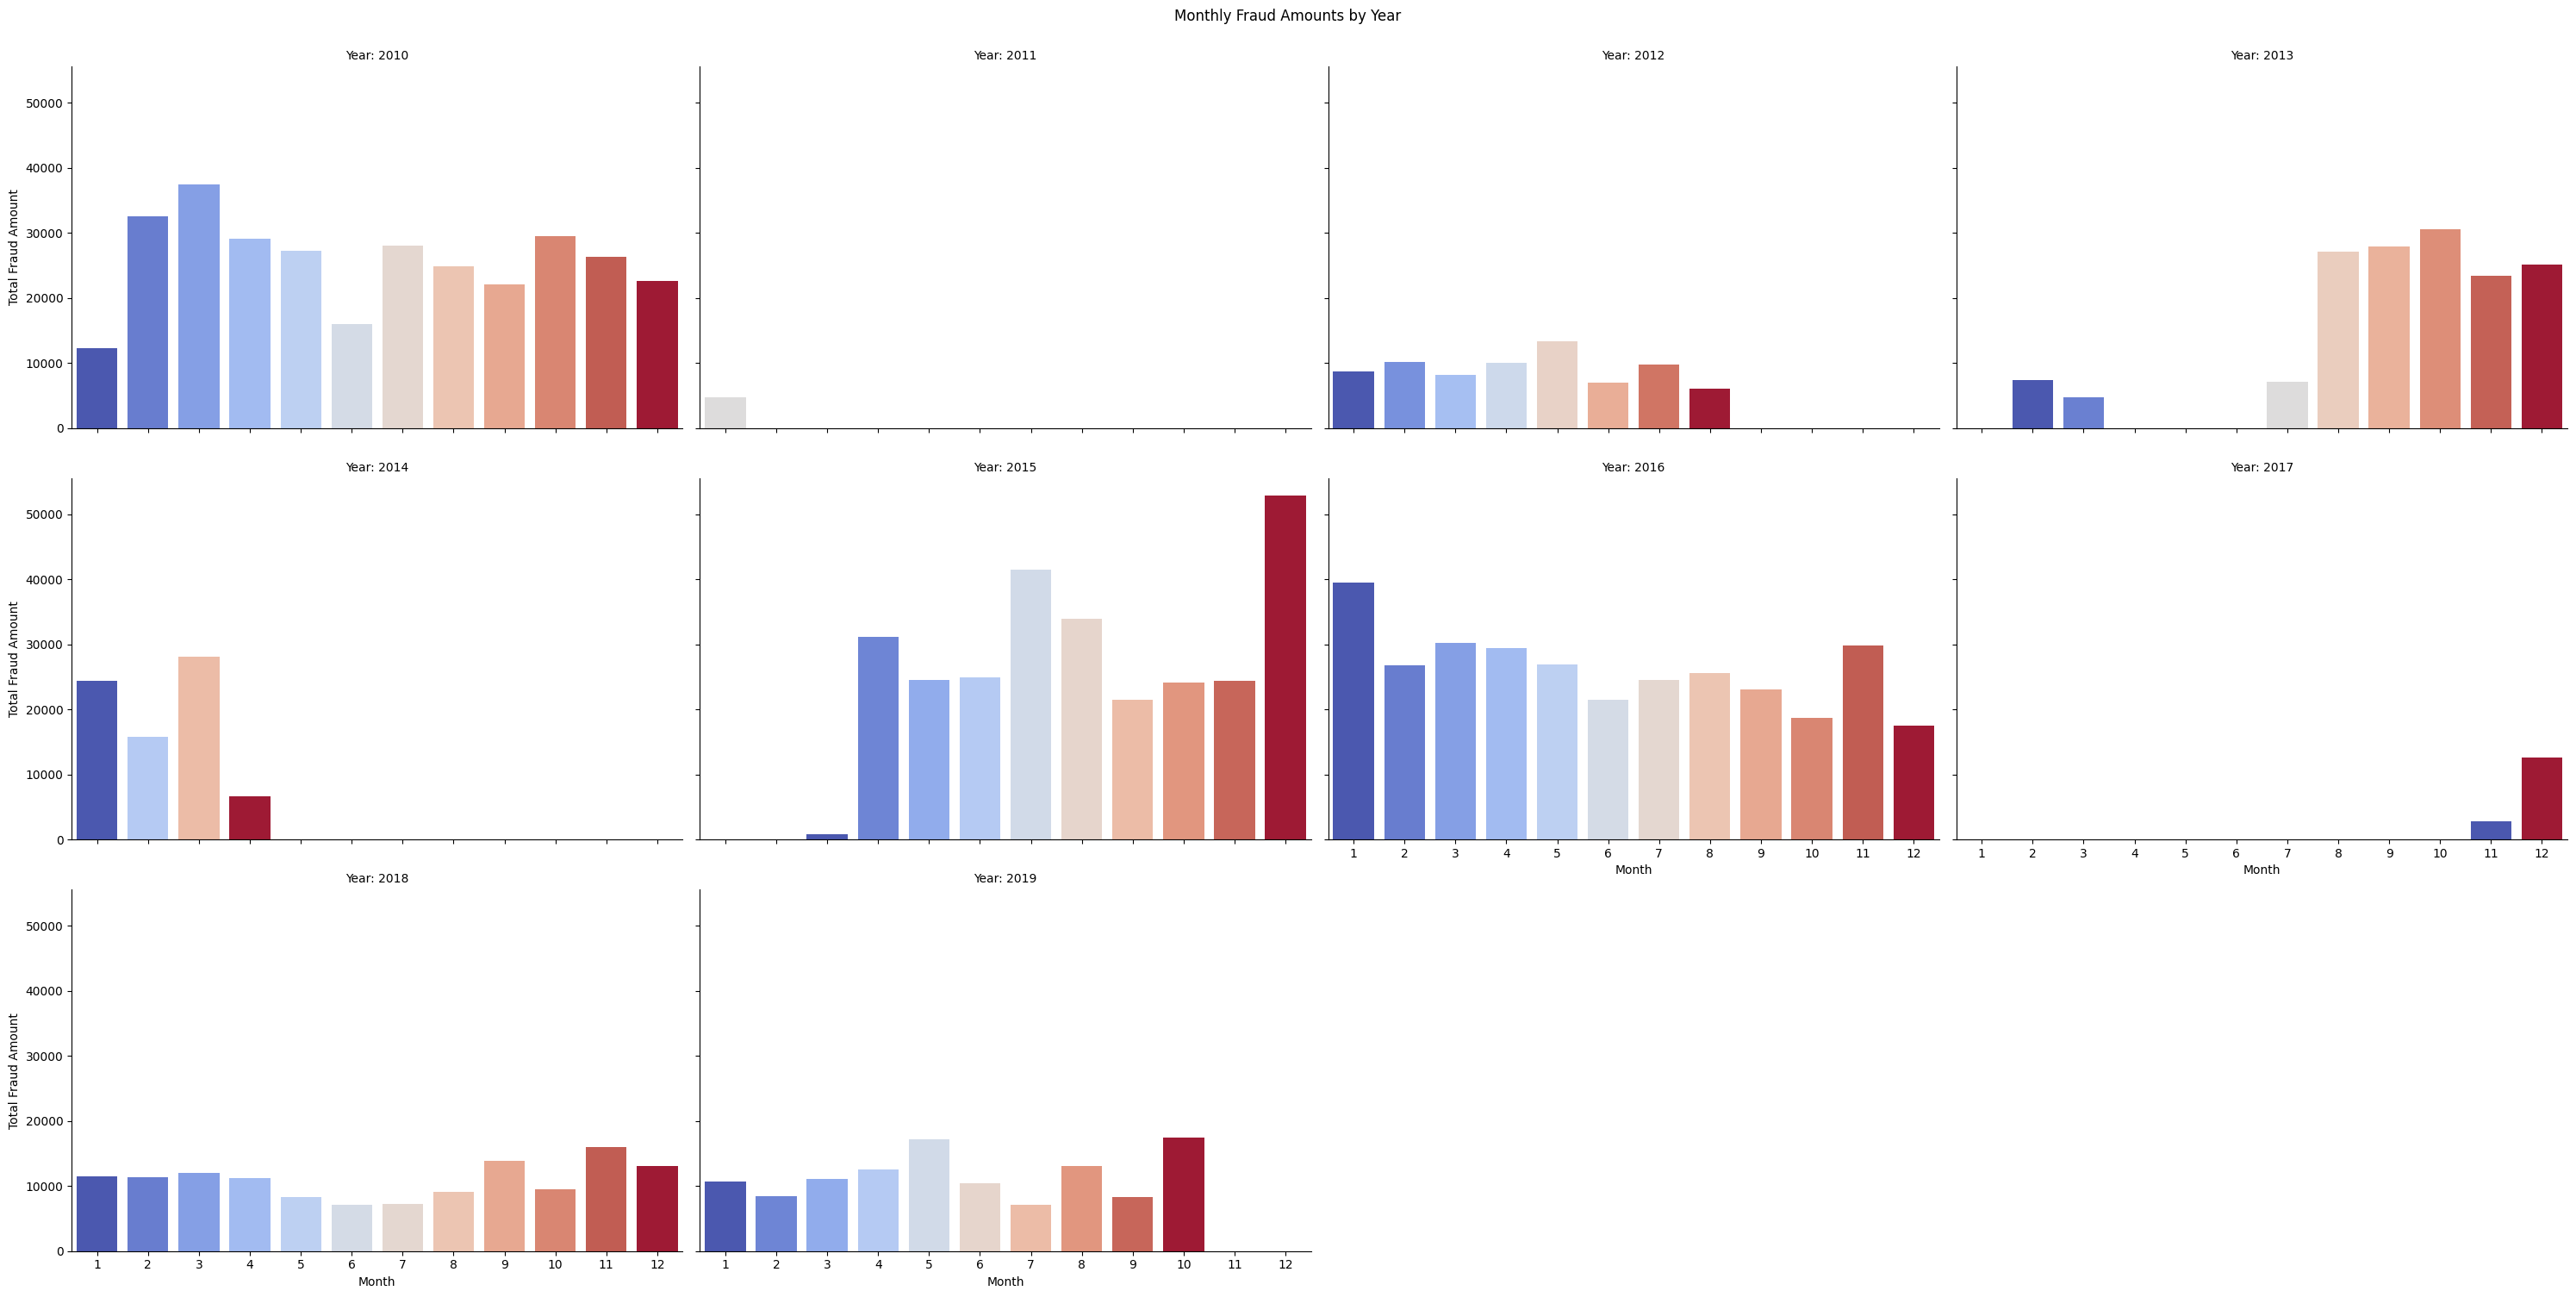

In [49]:
g = sns.FacetGrid(transaction_fraud_yes_grp_year_month, col="year", col_wrap=4, height=5, aspect=1.5)
g.map_dataframe(sns.barplot, x="month", y="total_amount", palette="coolwarm", hue = 'month')
g.set_titles("Year: {col_name}")
g.set_axis_labels("Month", "Total Fraud Amount")
g.fig.suptitle("Monthly Fraud Amounts by Year", y=1)
plt.tight_layout()
plt.show()

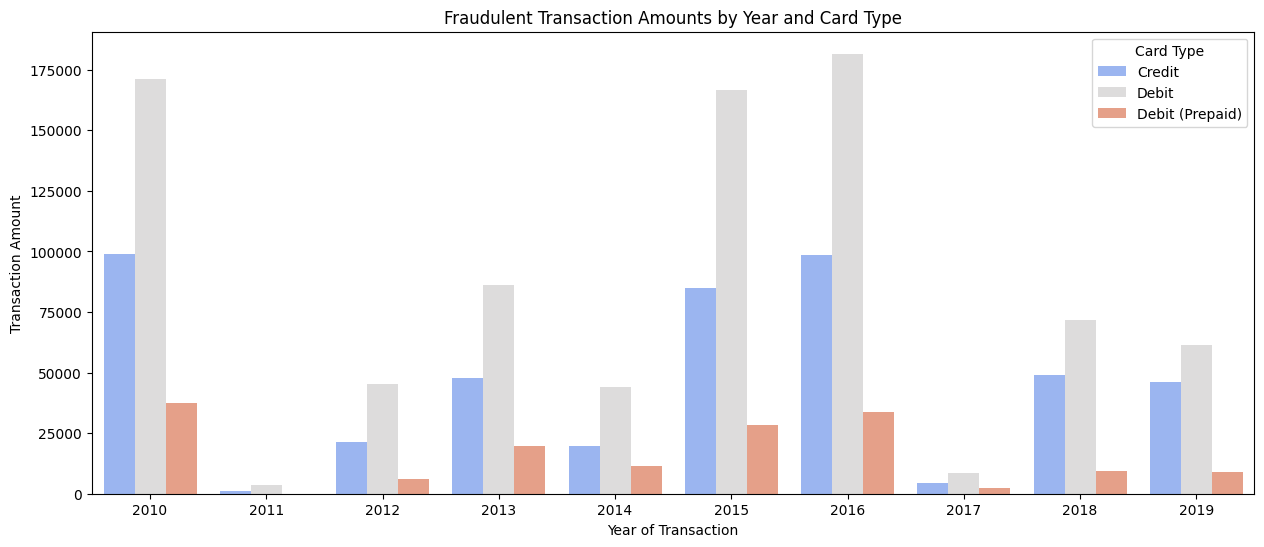

In [50]:
transaction_fraud_yes_grp_year_type = transaction_fraud_yes.groupby(['card_type','year'])['amount'].agg(
    mean_amount='mean',
    max_amount='max',
    min_amount='min',
    total_amount='sum',
    count = 'count'
)

transaction_fraud_yes_grp_year_mode = transaction_fraud_yes_grp_year_mode.reset_index()

plt.subplots( figsize = (15,6))
sns.barplot(x="year", y="total_amount", palette="coolwarm", hue = 'card_type', data =transaction_fraud_yes_grp_year_type)
plt.title("Fraudulent Transaction Amounts by Year and Card Type")
plt.xlabel("Year of Transaction")
plt.ylabel("Transaction Amount")
plt.legend(title="Card Type")
plt.show()

In [51]:
get_data_card(final_df)

Shape of given data is (8914963, 34)

Count of duplicate values is 0

Null Values ===> 

date                           0
client_id                      0
card_id                        0
amount                         0
transaction_mode               0
merchant_id                    0
merchant_city                  0
merchant_state           1047865
zip                      1107377
mcc                            0
error                    8773196
transaction_id                 0
fraud                          0
card_brand                     0
card_type                      0
expires                        0
has_chip                       0
num_cards_issued               0
credit_limit                   0
acct_open_date                 0
year_pin_last_changed          0
current_age                    0
retirement_age                 0
birth_year                     0
birth_month                    0
gender                         0
per_capita_income              0
yearly_income       

##### Date related analysis

In [52]:
date_fraud_df = transaction_fraud_yes[['client_id','date','month','year','current_age','has_chip','transaction_mode','card_brand','gender','fraud','amount']].copy()
date_fraud_df['day'] = date_fraud_df['date'].dt.day
date_fraud_df['day_name'] = date_fraud_df['date'].dt.day_name()
date_fraud_df['is_weekend'] = date_fraud_df['date'].dt.weekday >= 5
date_fraud_df['day_type'] = date_fraud_df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
date_fraud_df['hour'] = date_fraud_df['date'].dt.hour
date_fraud_df['hour_minute'] = date_fraud_df['date'].dt.strftime('%H:%M')
date_fraud_df.head()

,client_id,date,month,year,current_age,has_chip,transaction_mode,card_brand,gender,fraud,amount,day,day_name,is_weekend,day_type,hour,hour_minute
3459,126,2010-01-01 23:56:00,1,2010,63,YES,Online Transaction,Mastercard,Male,Yes,0.19,1,Friday,False,Weekday,23,23:56
9526,126,2010-01-03 20:58:00,1,2010,63,YES,Online Transaction,Mastercard,Male,Yes,339.00,3,Sunday,True,Weekend,20,20:58
12989,720,2010-01-04 23:30:00,1,2010,36,YES,Online Transaction,Mastercard,Female,Yes,4.45,4,Monday,False,Weekday,23,23:30
13000,720,2010-01-04 23:48:00,1,2010,36,YES,Online Transaction,Mastercard,Female,Yes,7.19,4,Monday,False,Weekday,23,23:48
13081,1644,2010-01-05 02:34:00,1,2010,83,YES,Online Transaction,Visa,Male,Yes,8.76,5,Tuesday,False,Weekday,2,02:34


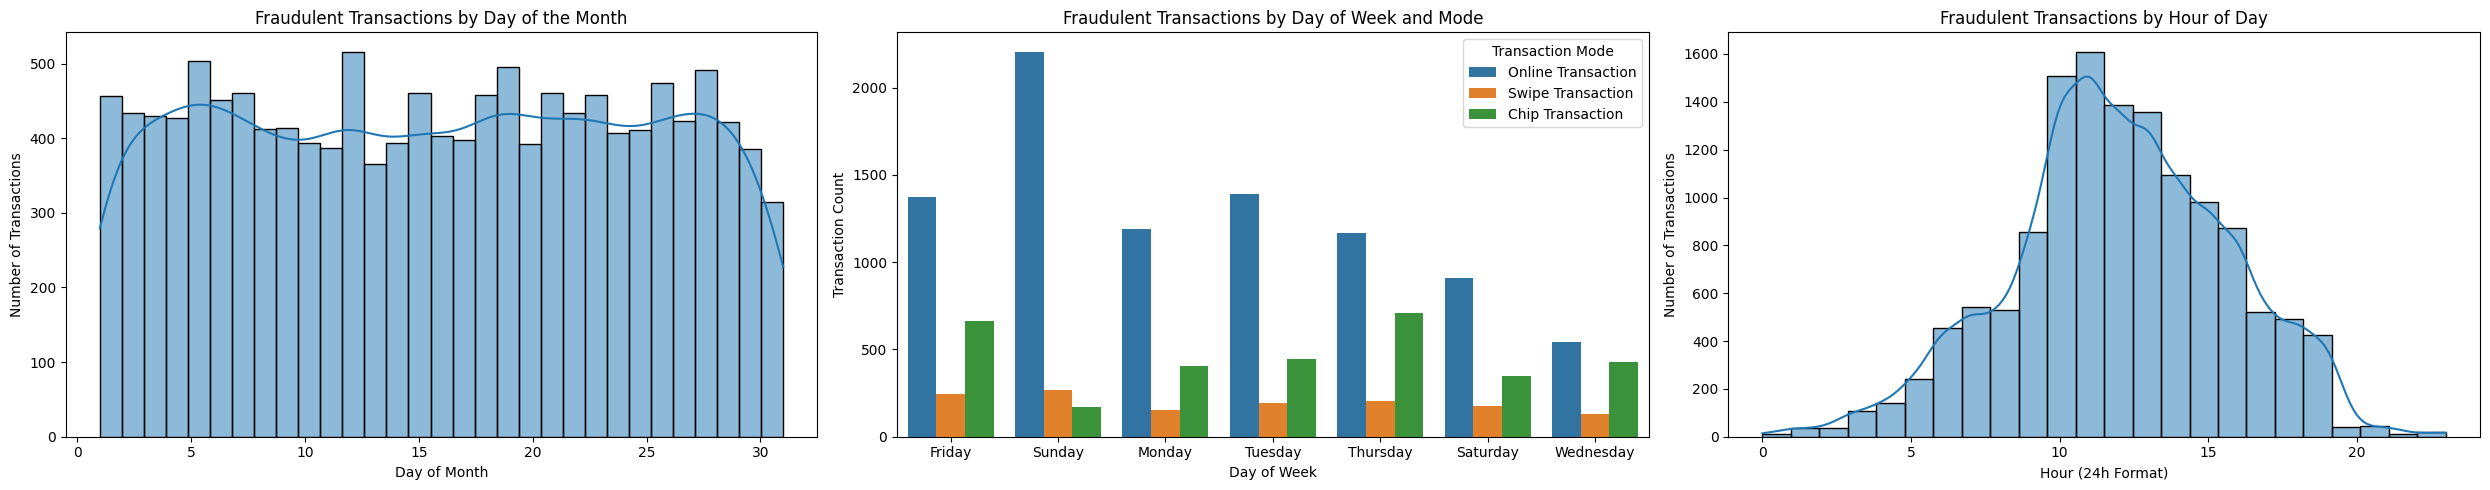

In [53]:
fig, ax = plt.subplots(1,3, figsize = (25,5))

sns.histplot(data=date_fraud_df, x='day', bins=31, kde=True,ax=ax[0])
ax[0].set_title("Fraudulent Transactions by Day of the Month")
ax[0].set_xlabel("Day of Month")
ax[0].set_ylabel("Number of Transactions")

sns.countplot(data=date_fraud_df, x='day_name', hue='transaction_mode',ax=ax[1])
ax[1].set_title("Fraudulent Transactions by Day of Week and Mode")
ax[1].set_xlabel("Day of Week")
ax[1].set_ylabel("Transaction Count")
ax[1].legend(title="Transaction Mode")

sns.histplot(data=date_fraud_df, x='hour', bins=24, kde=True,ax=ax[2])
ax[2].set_title("Fraudulent Transactions by Hour of Day")
ax[2].set_xlabel("Hour (24h Format)")
ax[2].set_ylabel("Number of Transactions")


plt.tight_layout()
plt.show()

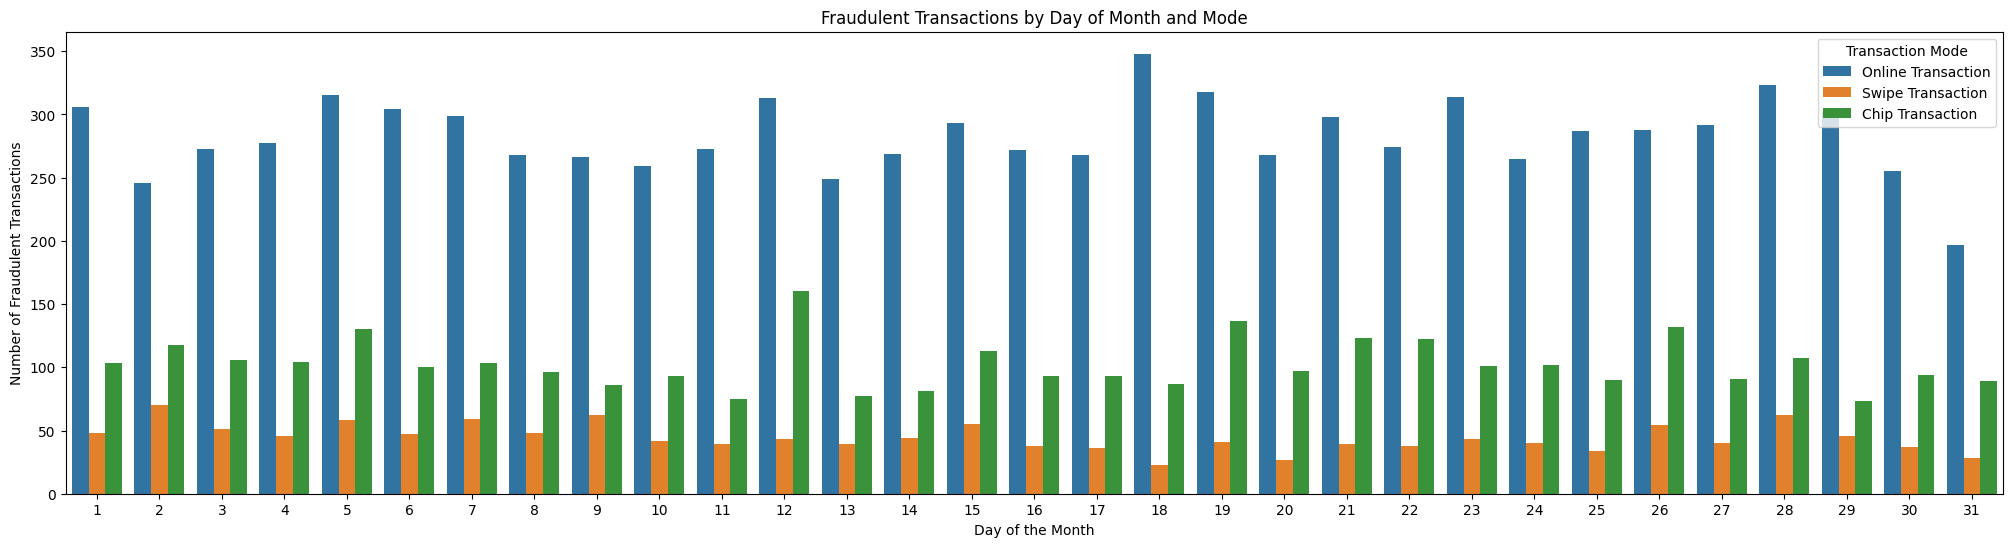

In [54]:
fig, ax = plt.subplots(figsize = (25,6))
sns.countplot(data=date_fraud_df, x='day',hue='transaction_mode')
plt.title("Fraudulent Transactions by Day of Month and Mode")
plt.xlabel("Day of the Month")
plt.ylabel("Number of Fraudulent Transactions")
plt.legend(title="Transaction Mode")
plt.show()

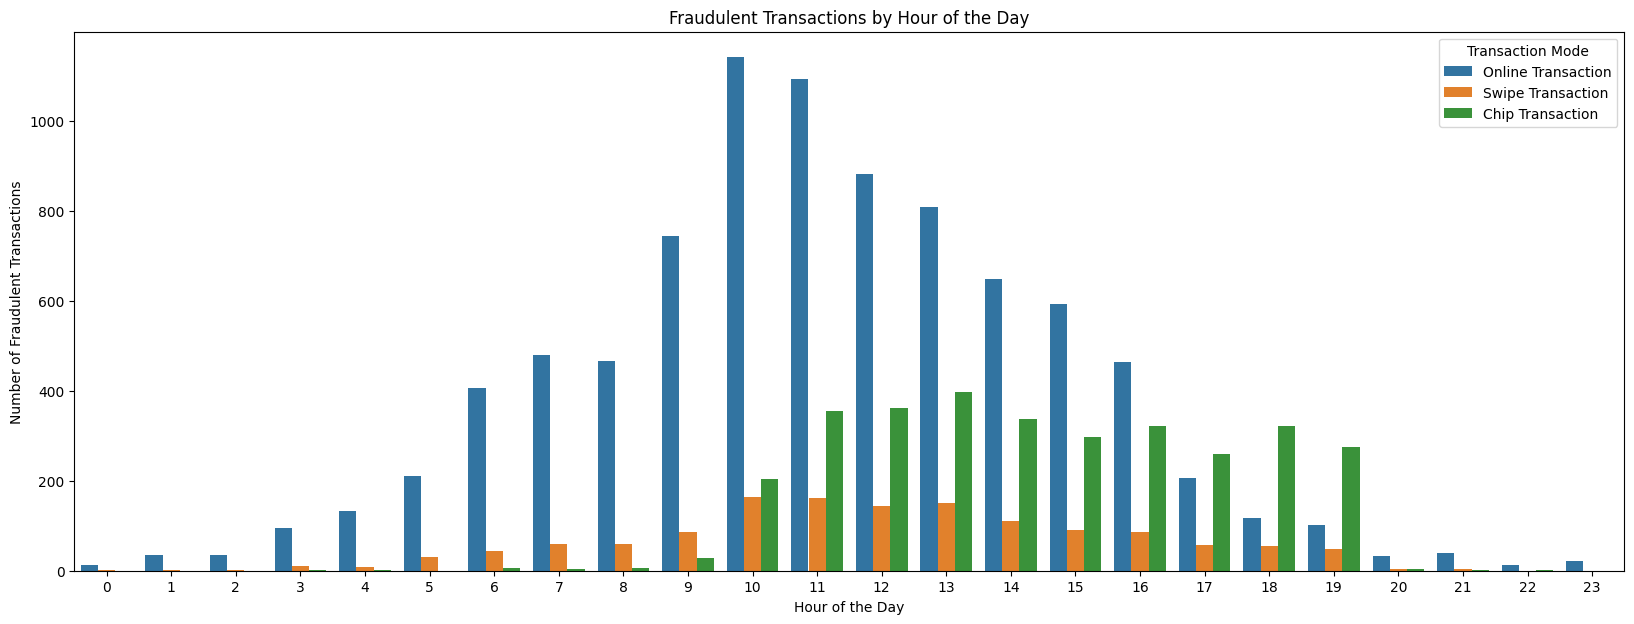

In [55]:
fig, ax = plt.subplots(figsize = (20,7))
sns.countplot(data=date_fraud_df, x='hour',hue='transaction_mode')
plt.title("Fraudulent Transactions by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Fraudulent Transactions")
plt.legend(title="Transaction Mode")
plt.show()

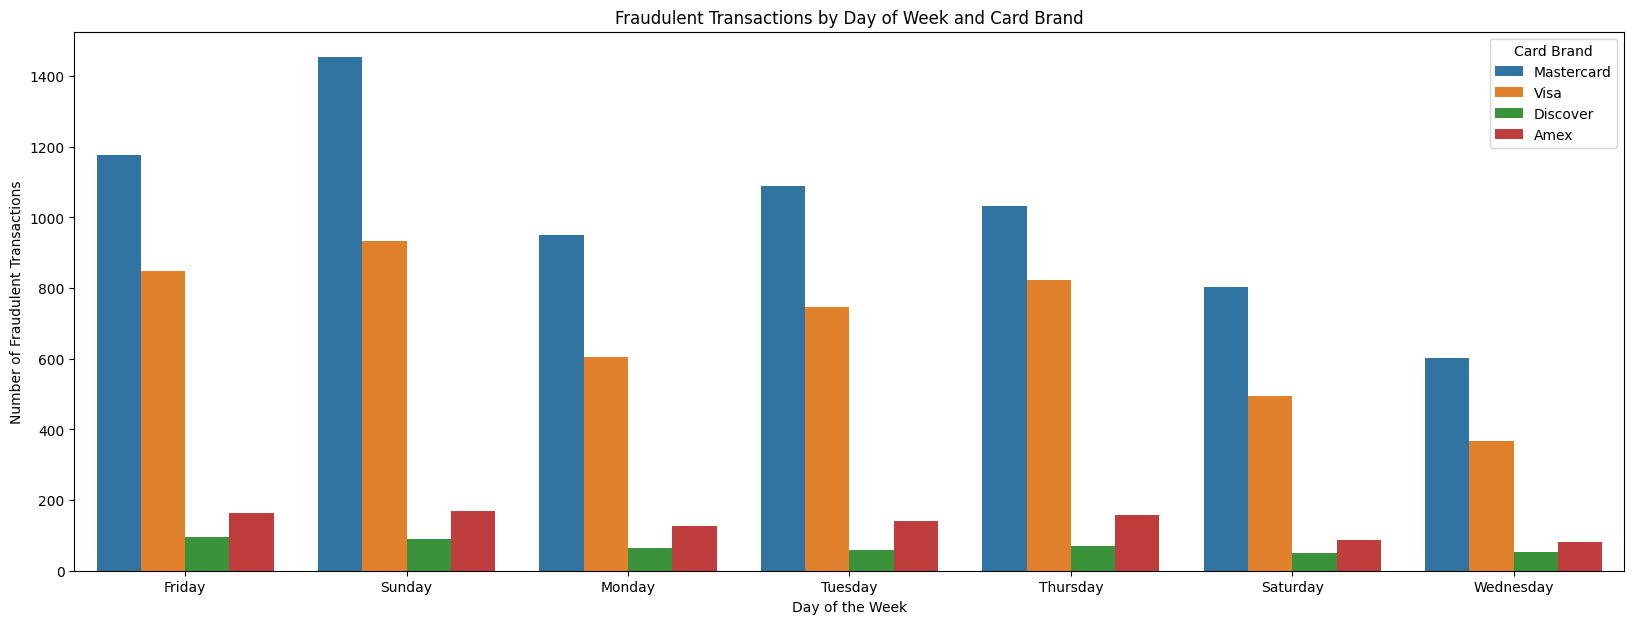

In [56]:
fig, ax = plt.subplots(figsize = (20,7))
sns.countplot(data=date_fraud_df, x='day_name',hue='card_brand')
plt.title("Fraudulent Transactions by Day of Week and Card Brand")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Fraudulent Transactions")
plt.legend(title="Card Brand")
plt.show()

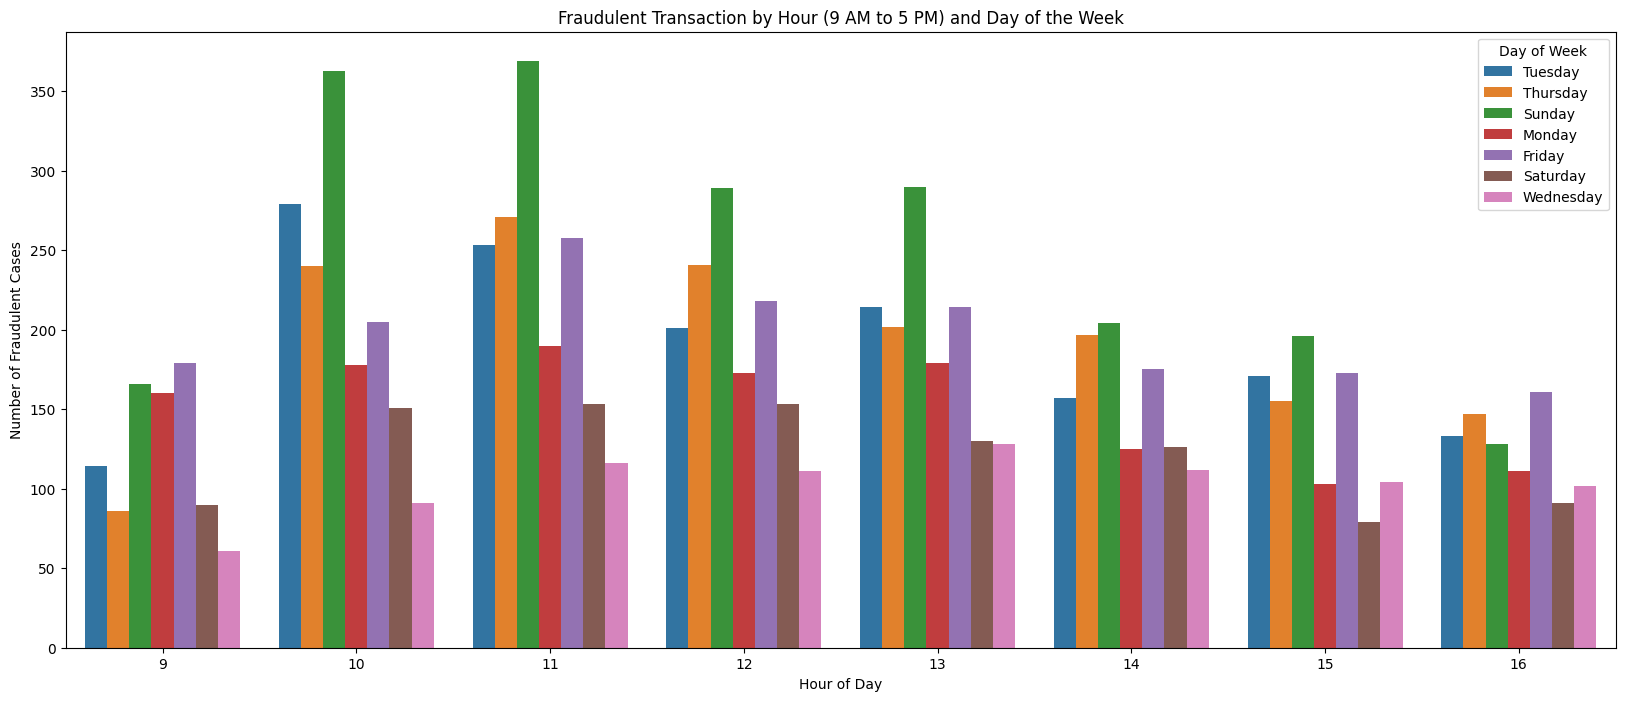

In [57]:
fig, ax = plt.subplots(figsize = (20,8))
sns.countplot(data=date_fraud_df[(date_fraud_df.hour>=9) & (date_fraud_df.hour<17)], x='hour',hue='day_name')
plt.title("Fraudulent Transaction by Hour (9 AM to 5 PM) and Day of the Week")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Fraudulent Cases")
plt.legend(title="Day of Week")
plt.show()

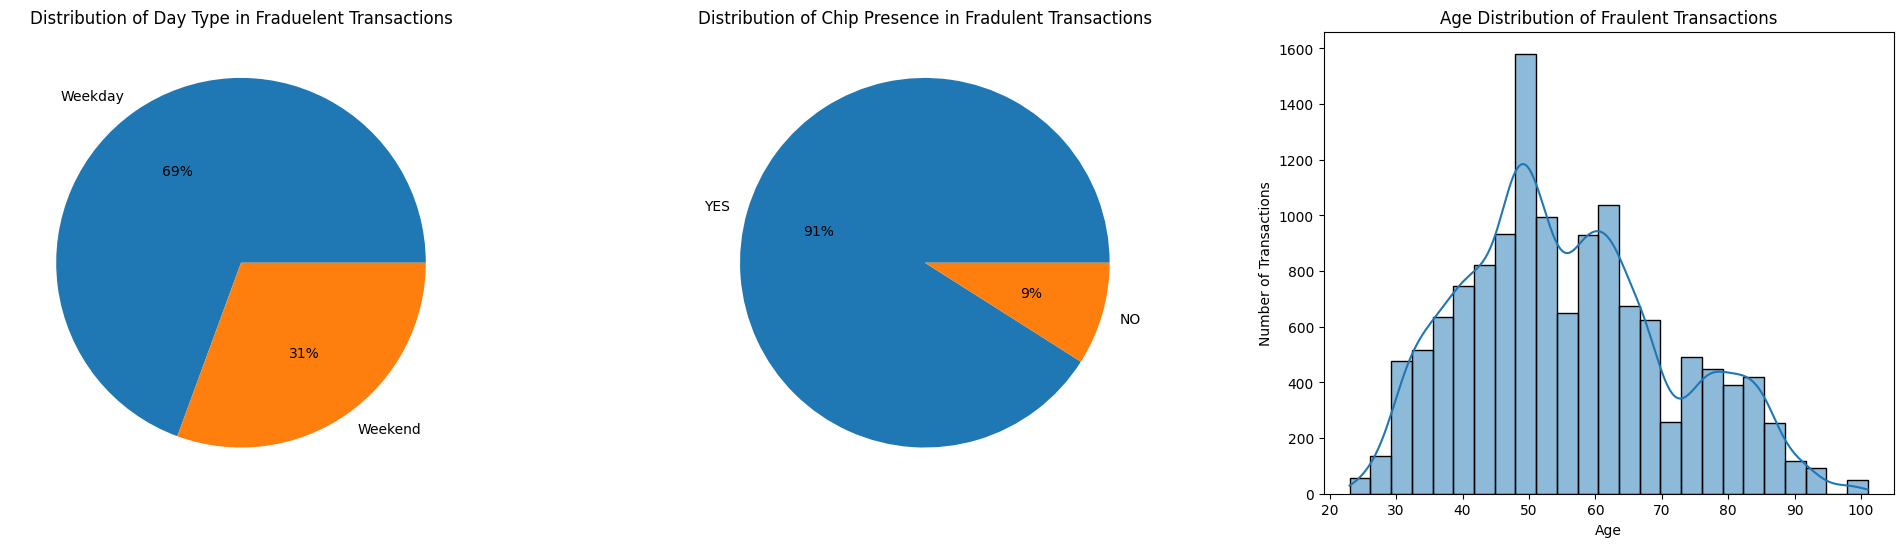

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))

labels = date_fraud_df.day_type.value_counts().index.tolist()
data = date_fraud_df.day_type.value_counts().values
palette_color = sns.color_palette('tab10')
ax[0].pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
ax[0].set_title("Distribution of Day Type in Fraduelent Transactions")

labels = date_fraud_df.has_chip.value_counts().index.tolist()
data = date_fraud_df.has_chip.value_counts().values
ax[1].pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
ax[1].set_title("Distribution of Chip Presence in Fradulent Transactions")

sns.histplot(data=date_fraud_df, x='current_age', bins=25, kde=True)
ax[2].set_title("Age Distribution of Fraulent Transactions")
ax[2].set_xlabel("Age")
ax[2].set_ylabel("Number of Transactions")
plt.show()

plt.show()


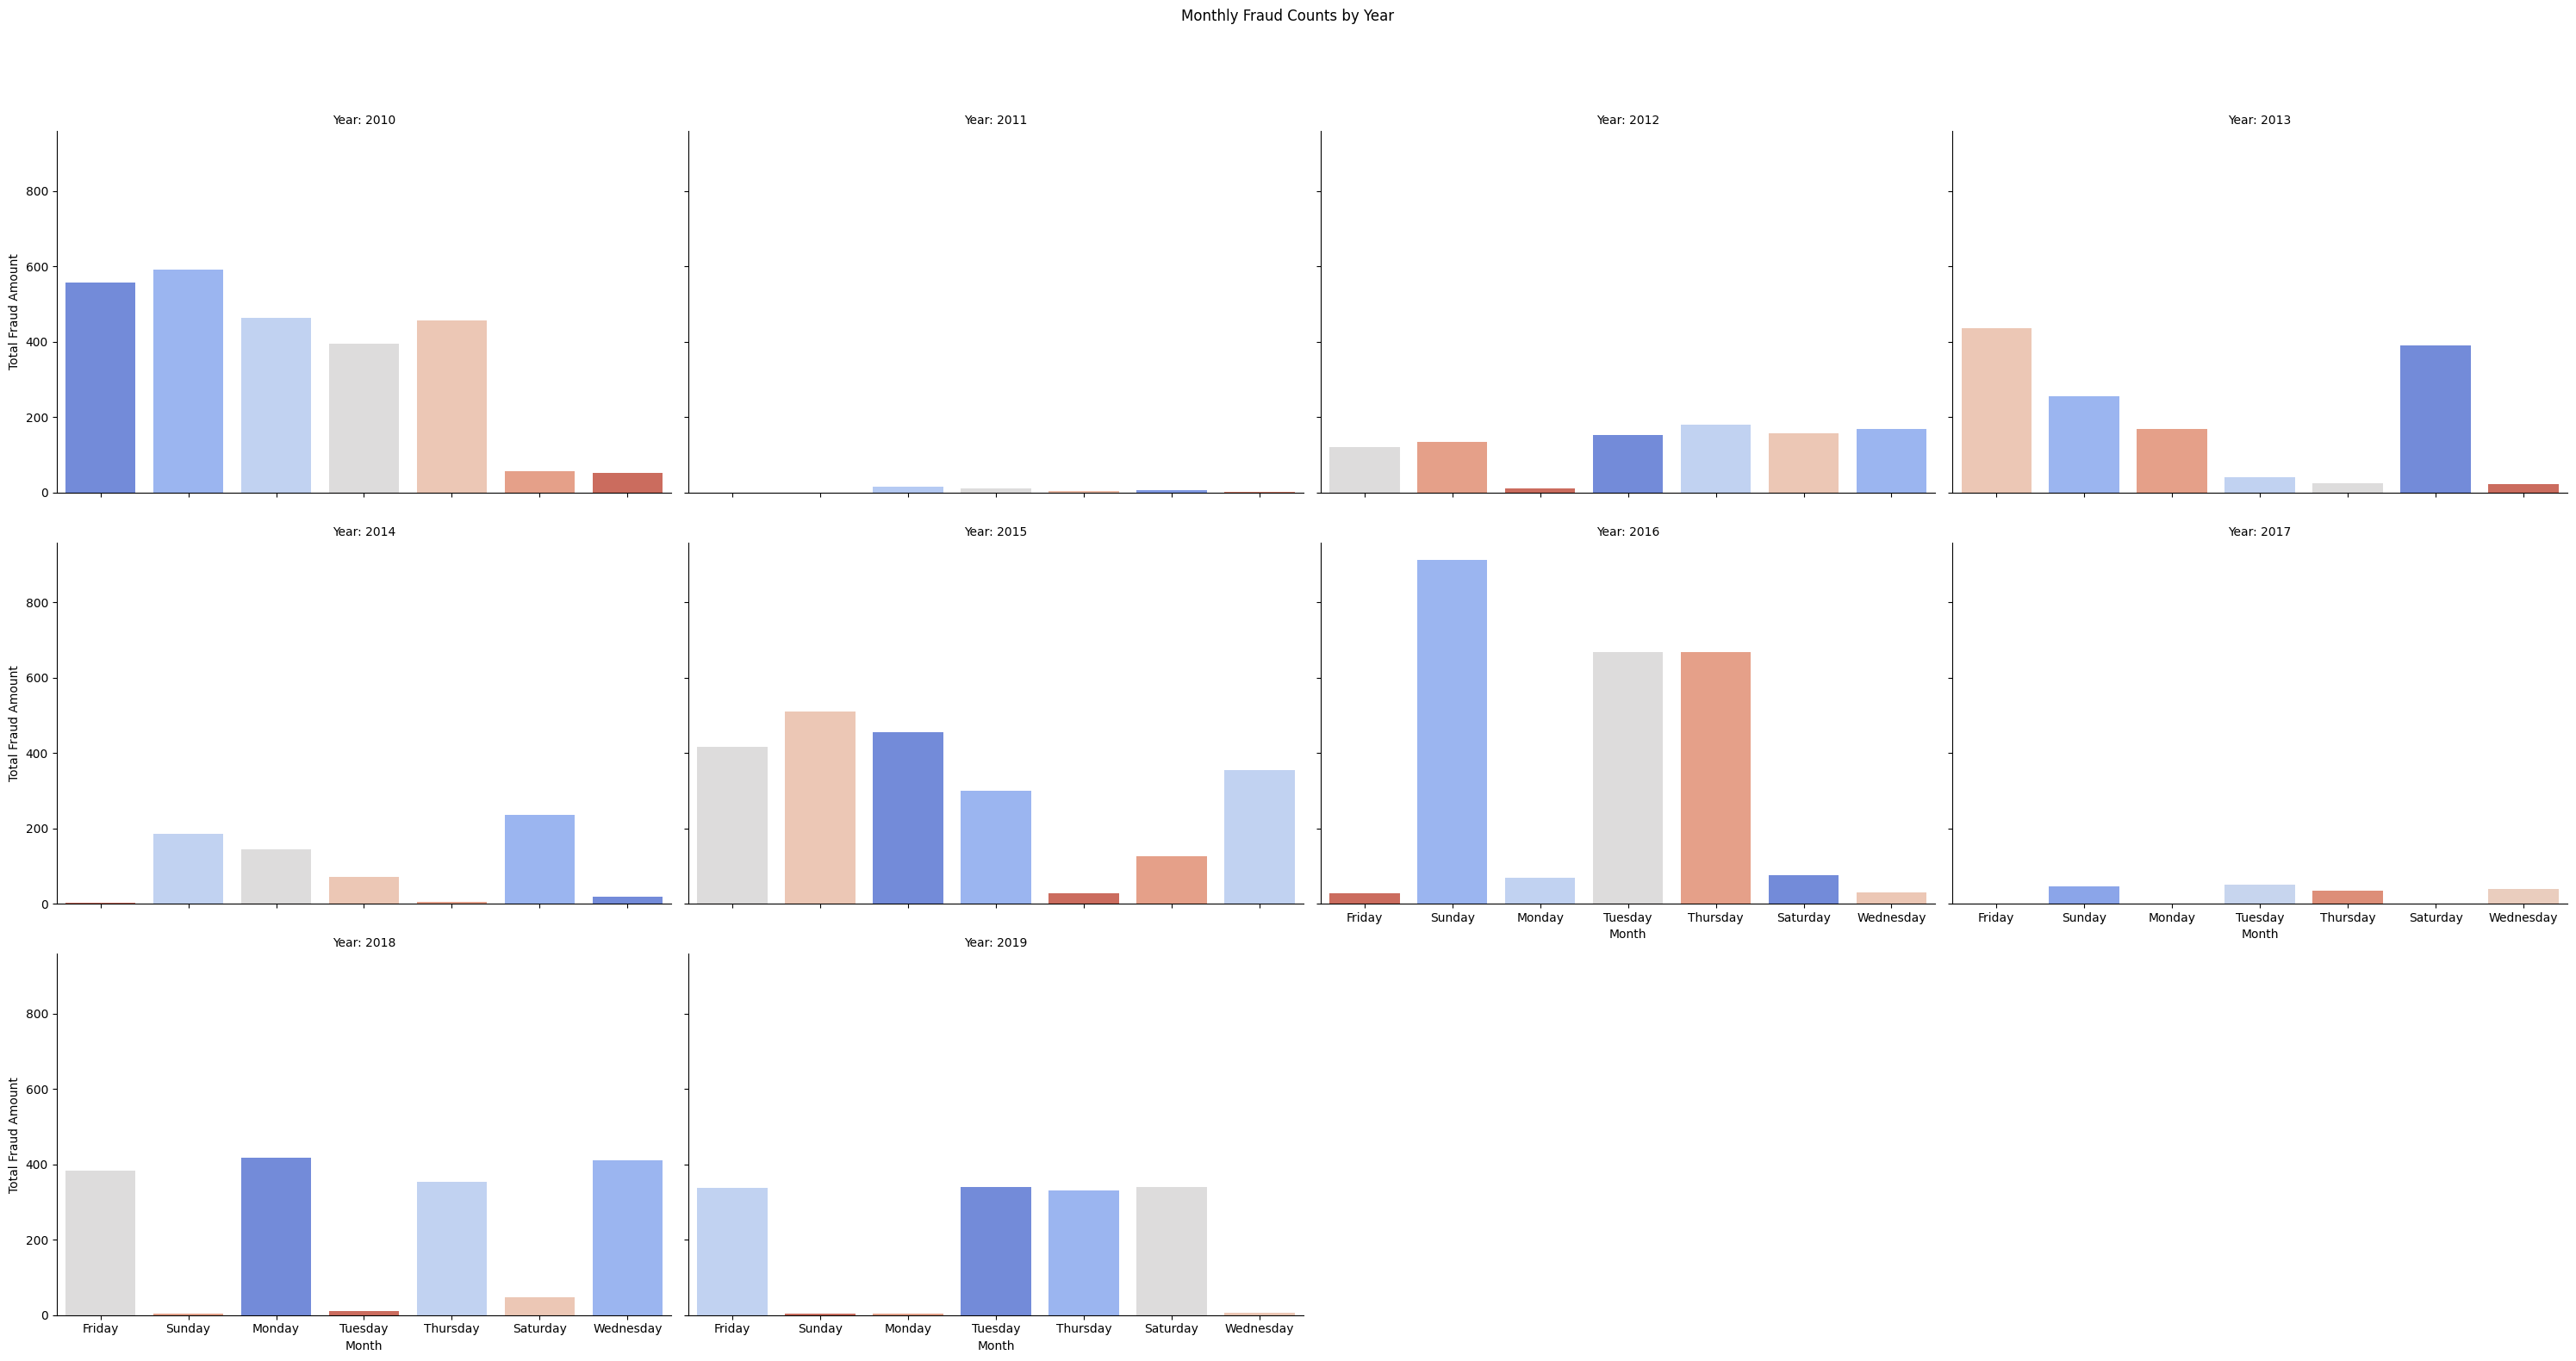

In [59]:
g = sns.FacetGrid(date_fraud_df, col="year", col_wrap=4, height=5, aspect=1.5)
g.map_dataframe(sns.countplot, x="day_name", palette="coolwarm", hue = 'day_name')
g.set_titles("Year: {col_name}")
g.set_axis_labels("Month", "Total Fraud Amount")
g.fig.suptitle("Monthly Fraud Counts by Year", y=1.05)
plt.tight_layout()
plt.show()

In [60]:
date_fraud_df.head()

,client_id,date,month,year,current_age,has_chip,transaction_mode,card_brand,gender,fraud,amount,day,day_name,is_weekend,day_type,hour,hour_minute
3459,126,2010-01-01 23:56:00,1,2010,63,YES,Online Transaction,Mastercard,Male,Yes,0.19,1,Friday,False,Weekday,23,23:56
9526,126,2010-01-03 20:58:00,1,2010,63,YES,Online Transaction,Mastercard,Male,Yes,339.00,3,Sunday,True,Weekend,20,20:58
12989,720,2010-01-04 23:30:00,1,2010,36,YES,Online Transaction,Mastercard,Female,Yes,4.45,4,Monday,False,Weekday,23,23:30
13000,720,2010-01-04 23:48:00,1,2010,36,YES,Online Transaction,Mastercard,Female,Yes,7.19,4,Monday,False,Weekday,23,23:48
13081,1644,2010-01-05 02:34:00,1,2010,83,YES,Online Transaction,Visa,Male,Yes,8.76,5,Tuesday,False,Weekday,2,02:34


### EDA

In [61]:
final_df['neg_amount'] = np.where(final_df['amount']<0,'Yes','No')
final_df['transaction_id'] = final_df['transaction_id'].astype('int')
final_df['fraud'] = final_df['fraud'].map({'Yes': 1, 'No': 0})
final_df['fraud'] = final_df['fraud'].astype('int')
final_df['log_amount'] = np.log1p(final_df.amount)
final_df['day'] = final_df['date'].dt.day
final_df['day_name'] = final_df['date'].dt.day_name()
final_df['is_weekend'] = final_df['date'].dt.weekday >= 5
final_df['day_type'] = final_df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
final_df['hour'] = final_df['date'].dt.hour
final_df.head()

C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\2845459094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['neg_amount'] = np.where(final_df['amount']<0,'Yes','No')
C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\2845459094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['transaction_id'] = final_df['transaction_id'].astype('int')
C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\2845459094.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description,year,month,neg_amount,log_amount,day,day_name,is_weekend,day_type,hour
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,7475327,0,Mastercard,Debit (Prepaid),07/2022,YES,2,55.0,05/2008,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores,2010,1,Yes,NaN,1,Friday,False,Weekday,0
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,7475328,0,Mastercard,Credit,12/2024,YES,1,9100.0,09/2005,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores,2010,1,No,2.745346,1,Friday,False,Weekday,0
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,7475329,0,Mastercard,Debit,05/2020,YES,1,14802.0,01/2006,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer,2010,1,No,4.394449,1,Friday,False,Weekday,0
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,7475332,0,Visa,Debit,01/2020,YES,1,19113.0,07/2009,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages),2010,1,No,3.858833,1,Friday,False,Weekday,0
5,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464,5942,None,7475333,0,Mastercard,Debit (Prepaid),03/2014,YES,1,89.0,01/2008,2015,47,65,1972,12,Female,25537.0,52065.0,98613.0,828,5,Book Stores,2010,1,No,1.759581,1,Friday,False,Weekday,0


#### Feature Analyis

In [62]:
final_df[['gender', 'fraud']].groupby(['gender']).mean().sort_values('fraud',ascending=False).reset_index()

,gender,fraud
0,Female,0.001529
1,Male,0.001461


In [63]:
final_df[['has_chip', 'fraud']].groupby(['has_chip']).mean().sort_values('fraud',ascending=False).reset_index()

,has_chip,fraud
0,YES,0.001512
1,NO,0.001345


In [64]:
final_df[['neg_amount', 'fraud']].groupby(['neg_amount']).mean().sort_values('fraud',ascending=False).reset_index()

,neg_amount,fraud
0,No,0.001516
1,Yes,0.001107


##### Account Opening Date and Expiry Date

In [65]:
final_df['acct_open_date'] = pd.to_datetime(final_df['acct_open_date'], errors='coerce')
final_df['expires'] = pd.to_datetime(final_df['expires'], errors='coerce')


C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\3100862552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['acct_open_date'] = pd.to_datetime(final_df['acct_open_date'], errors='coerce')
C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\3100862552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['expires'] = pd.to_datetime(final_df['expires'], errors='coerce')


In [66]:
final_df['transaction_since_acct_open'] = round((((final_df['date'].dt.year - final_df['acct_open_date'].dt.year) * 12) + (final_df['date'].dt.month - final_df['acct_open_date'].dt.month))/12,3)
final_df['transaction_before_expires'] = round((((final_df['expires'].dt.year - final_df['date'].dt.year) * 12) + (final_df['expires'].dt.month  - final_df['date'].dt.month ))/12,3)

C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\3510242476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['transaction_since_acct_open'] = round((((final_df['date'].dt.year - final_df['acct_open_date'].dt.year) * 12) + (final_df['date'].dt.month - final_df['acct_open_date'].dt.month))/12,3)
C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\3510242476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['transaction_before_expires'] = round((((final_df['expires'].dt.year - final_df['d

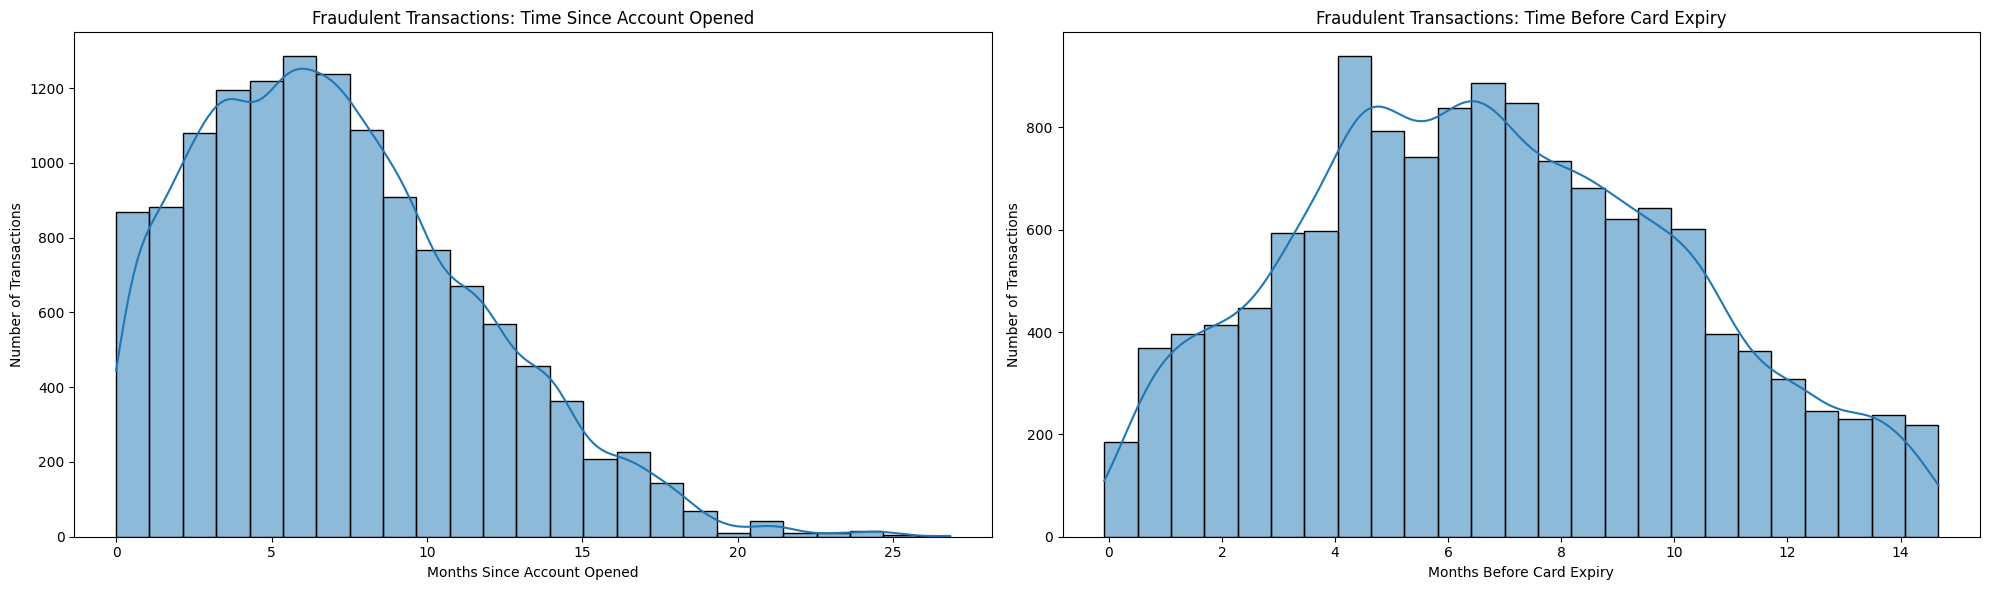

In [67]:
fig, ax = plt.subplots(1,2, figsize = (20,6))
sns.histplot(data=final_df[final_df.fraud==1], x='transaction_since_acct_open', bins=25, kde=True, ax=ax[0])
ax[0].set_title('Fraudulent Transactions: Time Since Account Opened')
ax[0].set_xlabel('Months Since Account Opened')
ax[0].set_ylabel('Number of Transactions')

sns.histplot(data=final_df[final_df.fraud==1], x='transaction_before_expires', bins=25, kde=True, ax=ax[1])
ax[1].set_title('Fraudulent Transactions: Time Before Card Expiry')
ax[1].set_xlabel('Months Before Card Expiry')
ax[1].set_ylabel('Number of Transactions')

plt.tight_layout()
plt.show()

C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\1887684221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['open_bin'] = pd.cut(final_df['transaction_since_acct_open'], bins=range(0, 30, 1))
C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\1887684221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['expire_bin'] = pd.cut(final_df['transaction_before_expires'], bins=range(0, 15, 1))
C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\1887684221.py:5: FutureWarning: The default of ob

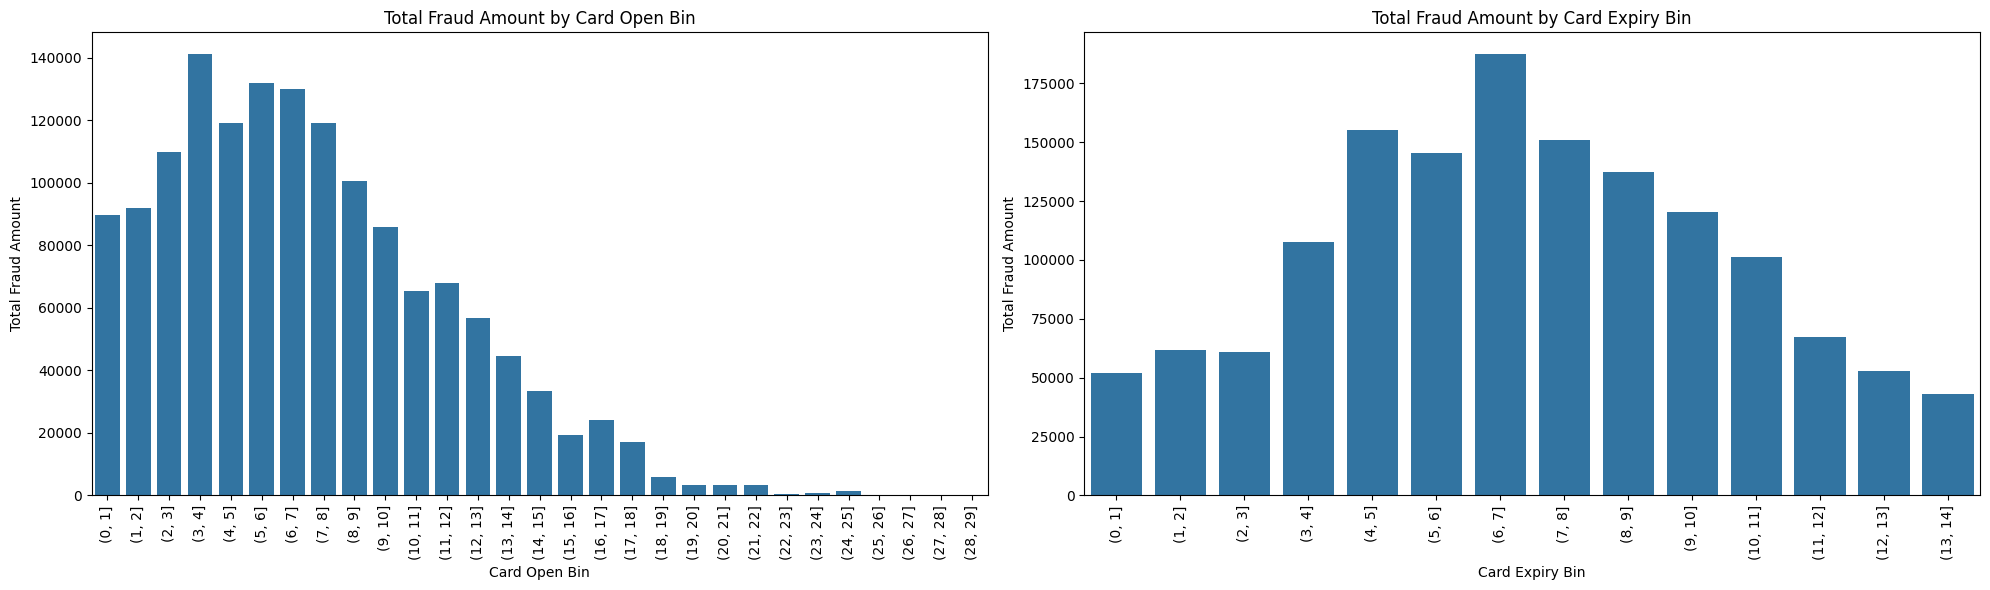

In [68]:
final_df['open_bin'] = pd.cut(final_df['transaction_since_acct_open'], bins=range(0, 30, 1))
final_df['expire_bin'] = pd.cut(final_df['transaction_before_expires'], bins=range(0, 15, 1))

fig, ax = plt.subplots(1,2, figsize = (20,6))
sns.barplot(data=final_df[final_df.fraud==1][['open_bin', 'amount']].groupby(['open_bin']).sum(), x='open_bin', y='amount',ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title('Total Fraud Amount by Card Open Bin')
ax[0].set_xlabel('Card Open Bin')
ax[0].set_ylabel('Total Fraud Amount')

sns.barplot(data=final_df[final_df.fraud==1][['expire_bin', 'amount']].groupby(['expire_bin']).sum(), x='expire_bin', y='amount',ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title('Total Fraud Amount by Card Expiry Bin')
ax[1].set_xlabel('Card Expiry Bin')
ax[1].set_ylabel('Total Fraud Amount')

plt.tight_layout()
plt.show()

##### Transaction Amount

In [69]:
final_df.groupby('fraud')['amount'].describe()


,count,mean,std,min,25%,50%,75%,max
fraud,,,,,,,,
0,8901631.0,42.848614,81.125350,-500.0,8.920,28.950,63.5700,6613.44
1,13332.0,110.234682,213.736207,-500.0,17.835,69.975,148.4925,4978.45


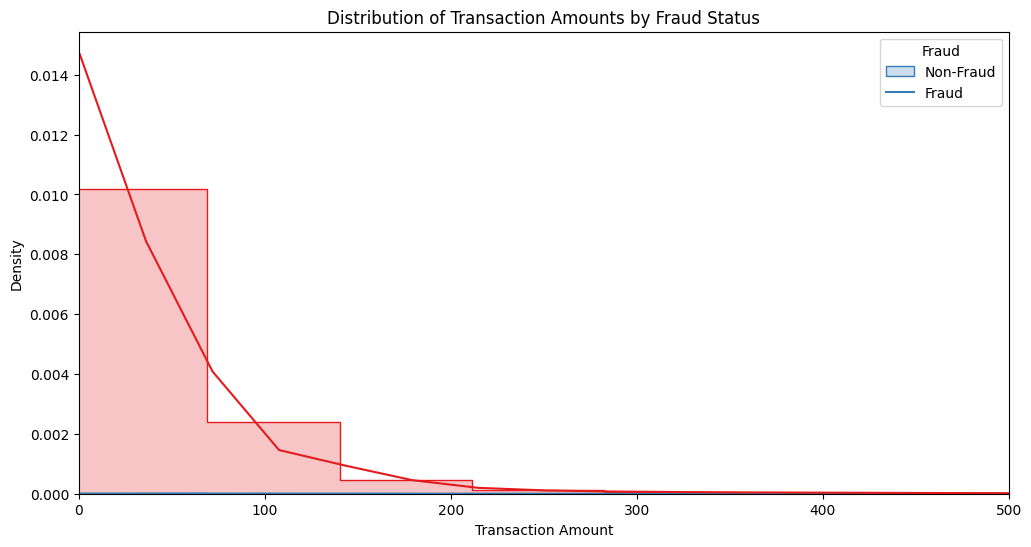

In [70]:
plt.figure(figsize=(12,6))
sns.histplot(data=final_df, x='amount', hue='fraud', bins=100, kde=True, stat='density', element='step', palette='Set1')
plt.xlim(0, 500)  # Adjust based on your distribution tail
plt.title("Distribution of Transaction Amounts by Fraud Status")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.legend(title="Fraud", labels=["Non-Fraud", "Fraud"])
plt.show()


C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\3933589017.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=final_df, x='fraud', y='amount', palette='Set2', inner='quartile')


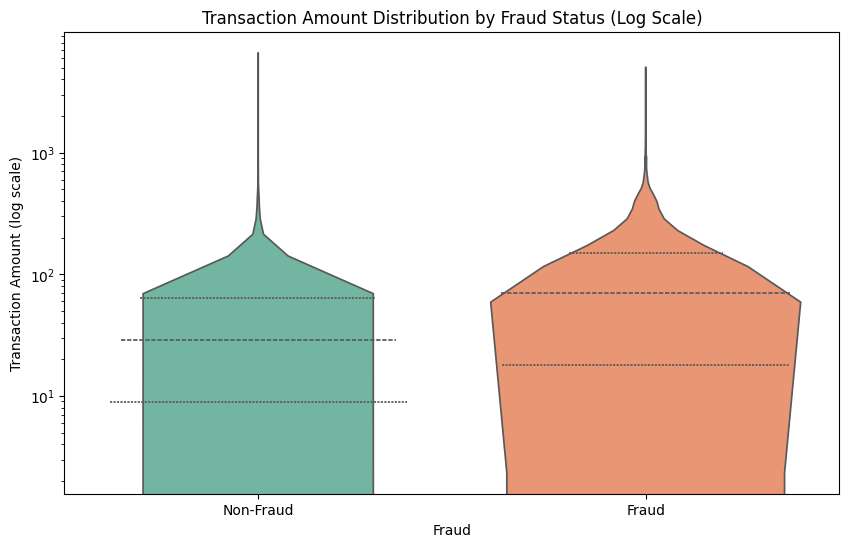

In [71]:
plt.figure(figsize=(10,6))
sns.violinplot(data=final_df, x='fraud', y='amount', palette='Set2', inner='quartile')
plt.yscale('log')  # Shows spread more clearly when data is skewed
plt.title("Transaction Amount Distribution by Fraud Status (Log Scale)")
plt.xlabel("Fraud")
plt.ylabel("Transaction Amount (log scale)")
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()


##### Errors

In [72]:
final_df.error.value_counts()

error
Insufficient Balance                                   87686
Bad PIN                                                21488
Technical Glitch                                       17776
Bad Card Number                                         5235
Bad CVV                                                 4091
Bad Expiration                                          4086
Bad Zipcode                                              767
Bad PIN,Insufficient Balance                             198
Insufficient Balance,Technical Glitch                    163
Bad Card Number,Insufficient Balance                      50
Bad PIN,Technical Glitch                                  44
Bad CVV,Insufficient Balance                              40
Bad Expiration,Insufficient Balance                       34
Bad Card Number,Bad Expiration                            28
Bad Card Number,Bad CVV                                   26
Bad Expiration,Bad CVV                                    21
Bad Expiration,Tec

In [73]:
final_df[final_df.fraud==1].error.value_counts()

error
Insufficient Balance                    169
Bad CVV                                 139
Bad PIN                                 112
Bad Card Number                          59
Bad Expiration                           54
Technical Glitch                         31
Bad CVV,Insufficient Balance              2
Bad Card Number,Insufficient Balance      1
Bad CVV,Technical Glitch                  1
Bad PIN,Insufficient Balance              1
Name: count, dtype: int64

##### MCC Codes

In [74]:
final_df.Description.value_counts()

Description
Grocery Stores, Supermarkets               1066833
Miscellaneous Food Stores                   979396
Service Stations                            955123
Eating Places and Restaurants               669808
Drug Stores and Pharmacies                  517400
                                            ...   
Miscellaneous Fabricated Metal Products        245
Bolt, Nut, Screw, Rivet Manufacturing          236
Household Appliance Stores                     226
Floor Covering Stores                          222
Music Stores - Musical Instruments             204
Name: count, Length: 108, dtype: int64

In [75]:
final_df[final_df.fraud==1].Description.value_counts()

Description
Department Stores                    2251
Wholesale Clubs                       991
Discount Stores                       859
Money Transfer                        725
Drug Stores and Pharmacies            479
                                     ... 
Cleaning and Maintenance Services       4
Medical Services                        2
Chiropractors                           2
Podiatrists                             1
Recreational Sports, Clubs              1
Name: count, Length: 97, dtype: int64

Is there a pattern in amount for fraud? Are small or large transactions more suspicious?
Do errors occur more in fraudulent transactions?
Which merchant_id, merchant_city, or merchant_state see more fraud?
Are frauds concentrated in specific zip codes or MCCs (merchant category codes)?
Are certain MCCs (e.g., electronics, jewelry) targeted more?
User Demo(All)

##### Top 30(TBC/TBD)

In [76]:
top30_fraud_clients = final_df[final_df.fraud==1].client_id.value_counts().head(30).index.to_list()
top30_clients = final_df.client_id.value_counts().head(30).index.to_list()

##### Merchant City and Merchant State along with Years

In [77]:
final_df[final_df.fraud==1].merchant_city.value_counts().head(5)

merchant_city
ONLINE            8779
Rome              3061
Port au Prince     253
Strasburg          213
Sugarcreek          23
Name: count, dtype: int64

In [78]:
final_df[final_df.fraud==1].merchant_state.value_counts().head(5)

merchant_state
Italy    3061
OH        316
Haiti     253
CA        127
TX         76
Name: count, dtype: int64

In [79]:
final_df[final_df.fraud==1].merchant_id.value_counts()

merchant_id
60569    764
27092    725
48919    332
99370    302
32858    289
        ... 
29291      1
80043      1
60151      1
78828      1
28236      1
Name: count, Length: 1090, dtype: int64

In [80]:
final_df[final_df.merchant_state=='Italy'].fraud.mean()

np.float64(0.6504462388440289)

In [81]:
final_df[final_df.merchant_state=='Italy'].Description.value_counts()

Description
Department Stores                                    710
Grocery Stores, Supermarkets                         536
Service Stations                                     448
Miscellaneous Food Stores                            366
Eating Places and Restaurants                        328
Discount Stores                                      245
Drug Stores and Pharmacies                           183
Family Clothing Stores                               162
Taxicabs and Limousines                              145
Fast Food Restaurants                                129
Non-Precious Metal Services                          108
Semiconductors and Related Devices                   106
Lumber and Building Materials                        103
Non-Ferrous Metal Foundries                          103
Drinking Places (Alcoholic Beverages)                 95
Industrial Equipment and Supplies                     93
Computers, Computer Peripheral Equipment              88
Passenger Railways 

In [82]:
final_df[(final_df.merchant_state=='Italy') & (final_df.fraud==1)].Description.value_counts()

Description
Department Stores                                    685
Grocery Stores, Supermarkets                         280
Discount Stores                                      236
Service Stations                                     160
Drug Stores and Pharmacies                           147
Family Clothing Stores                               147
Miscellaneous Food Stores                            131
Taxicabs and Limousines                              102
Lumber and Building Materials                         92
Computers, Computer Peripheral Equipment              88
Precious Stones and Metals                            87
Furniture, Home Furnishings, and Equipment Stores     85
Antique Shops                                         64
Passenger Railways                                    63
Eating Places and Restaurants                         60
Industrial Equipment and Supplies                     59
Drinking Places (Alcoholic Beverages)                 56
Non-Precious Metal 

In [83]:
final_df[(final_df.merchant_state == 'Italy') & (final_df.fraud == 1)].groupby(['year', 'month'])['amount'].agg(
        mean_amount='mean',
        max_amount='max',
        min_amount='min',
        total_amount='sum',
        count='count'
    )

mean_amount  max_amount  min_amount  total_amount  count
year month                                                          
2017 11       77.656389      510.24     -143.00       2795.63     36
     12       92.667868     1198.72        0.06      12602.83    136
2018 1       109.432857     1343.48     -345.00      11490.45    105
     2        94.369000      826.21        0.00      11324.28    120
     3        75.838491      754.53     -366.00      12058.32    159
     4        65.116127      892.57     -484.00      11265.09    173
     5        86.445521      526.70     -238.00       8298.77     96
     6        78.558111      926.60      -94.00       7070.23     90
     7        76.485789      588.78     -380.00       7266.15     95
     8        64.007535      566.11     -221.00       9089.07    142
     9        82.868155      878.96     -386.00      13921.85    168
     10       75.525714      695.64     -351.00       9516.24    126
     11       61.975469      728.81     -448.00       7932.86    128
     12       93.964646     1284.18        0.03      11933.51    127
2019 1        82.973023     1135.92     -183.00      10703.52    129
     2        74.324602      887.35        0.09       8398.68    113
     3        78.149296      821.19     -420.00      11097.20    142
     4        89.920643      866.75     -100.00      12588.89    140
     5       101.960774      900.44     -219.00      17129.41    168
     6        79.360606      878.03     -475.00      10475.60    132
     7        68.950096     1244.41     -216.00       7170.81    104
     8        79.522364      765.25     -405.00      13121.19    165
     9        92.127444      909.40     -367.00       8291.47     90
     10       98.456610     1111.01     -382.00      17426.82    177

In [84]:
final_df[(final_df.merchant_state == 'Italy') & (final_df.fraud == 1)].client_id.value_counts().head(20)

client_id
619     22
1809    22
1725    22
433     21
1523    21
209     20
1128    19
1882    19
1515    18
1926    18
1718    18
397     17
517     17
1345    17
1571    17
1644    16
1634    16
1648    16
1095    15
1098    15
Name: count, dtype: int64

##### Debt to Income Ratio

In [85]:
final_df['debt_income_ratio'] = final_df['total_debt']/final_df['yearly_income']

C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\2130343679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['debt_income_ratio'] = final_df['total_debt']/final_df['yearly_income']


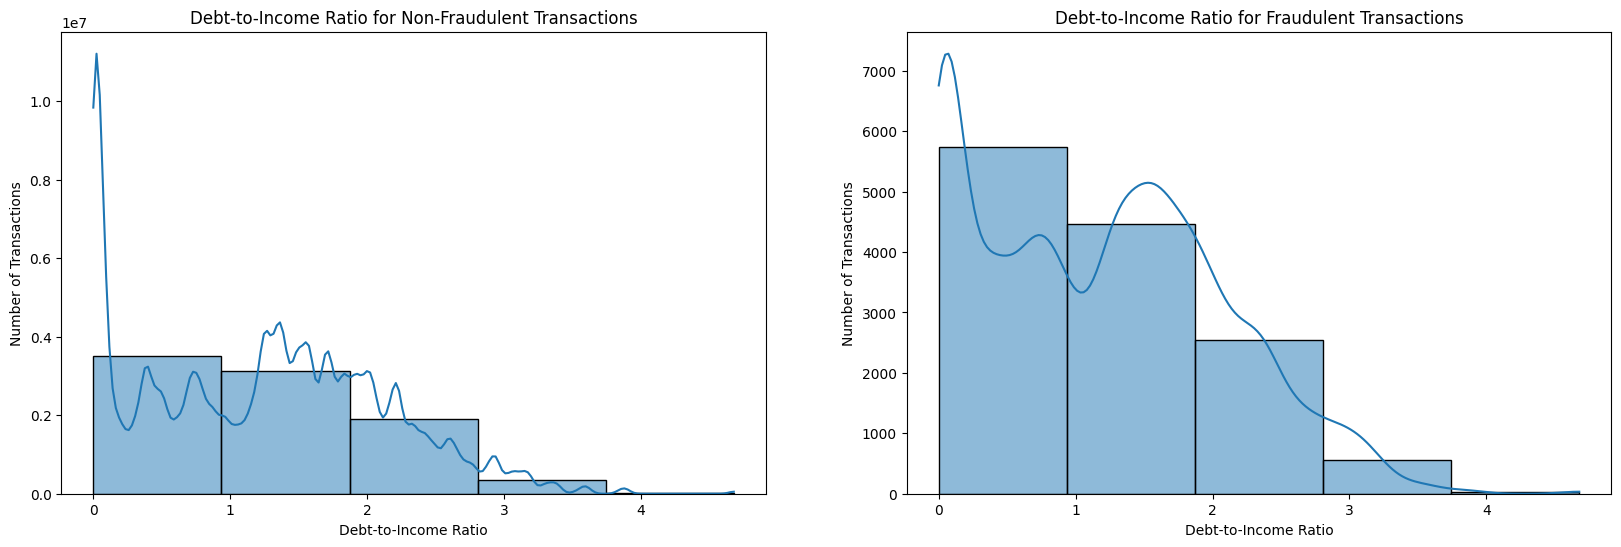

In [86]:
fig, ax = plt.subplots(1,2, figsize = (20,6))
sns.histplot(data=final_df[final_df.fraud==0], x='debt_income_ratio', bins=5, kde=True, ax=ax[0])
ax[0].set_title('Debt-to-Income Ratio for Non-Fraudulent Transactions')
ax[0].set_xlabel('Debt-to-Income Ratio')
ax[0].set_ylabel('Number of Transactions')

sns.histplot(data=final_df[final_df.fraud==1], x='debt_income_ratio', bins=5, kde=True, ax=ax[1])
ax[1].set_title('Debt-to-Income Ratio for Fraudulent Transactions')
ax[1].set_xlabel('Debt-to-Income Ratio')
ax[1].set_ylabel('Number of Transactions')

plt.show()

C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\3948709494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['debt_bin'] = pd.cut(final_df['debt_income_ratio'], bins=range(0, 5, 1))
C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\3948709494.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(data=final_df[final_df.fraud==1][['debt_bin', 'amount']].groupby(['debt_bin']).sum(), x='debt_bin', y='amount',ax=ax[0])
C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\3948709494.py:10: FutureWarning: The default of observed=False is depreca

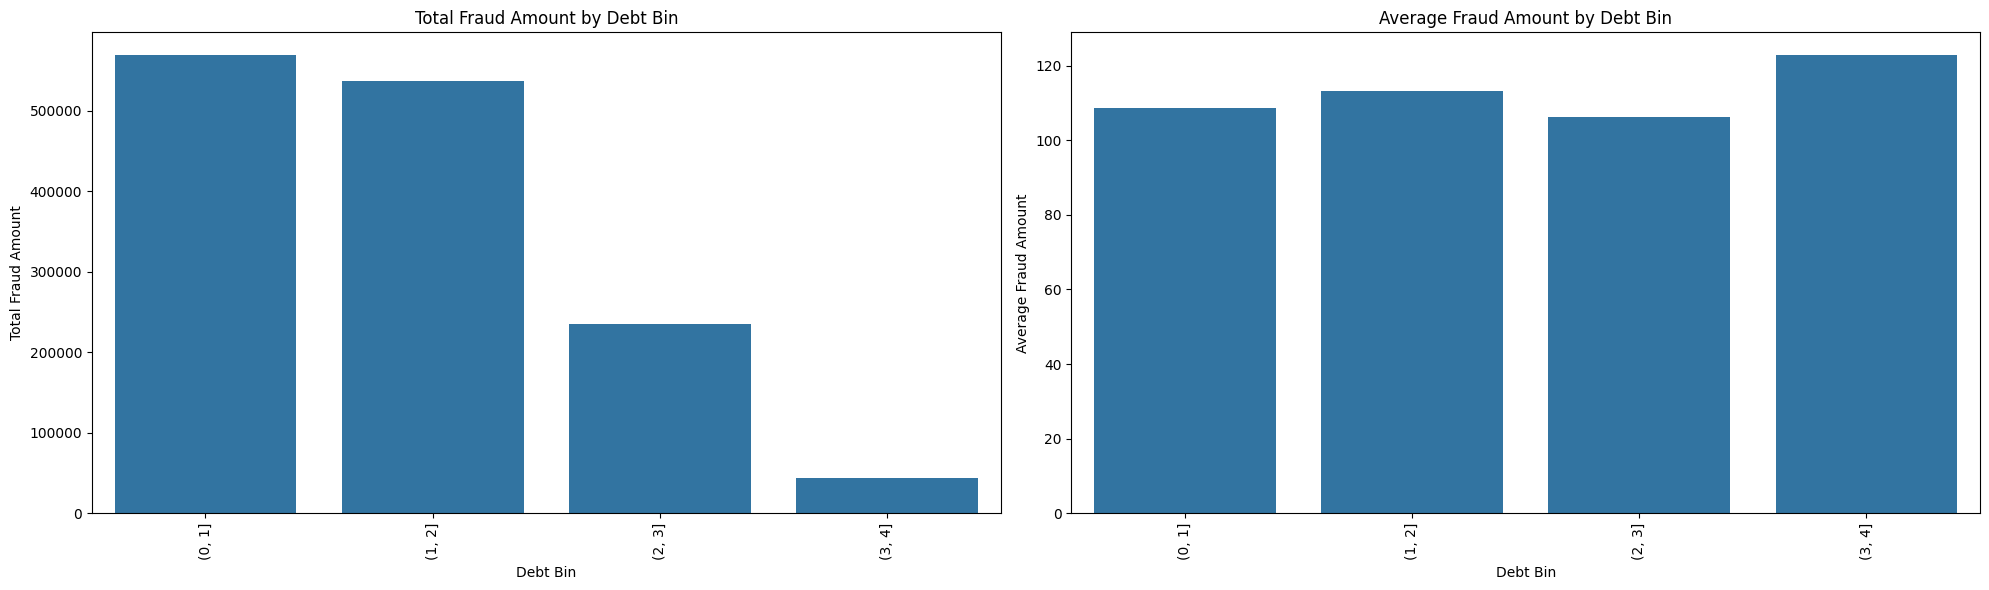

In [87]:
final_df['debt_bin'] = pd.cut(final_df['debt_income_ratio'], bins=range(0, 5, 1))

fig, ax = plt.subplots(1,2, figsize = (20,6))
sns.barplot(data=final_df[final_df.fraud==1][['debt_bin', 'amount']].groupby(['debt_bin']).sum(), x='debt_bin', y='amount',ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title('Total Fraud Amount by Debt Bin')
ax[0].set_xlabel('Debt Bin')
ax[0].set_ylabel('Total Fraud Amount')

sns.barplot(data=final_df[final_df.fraud==1][['debt_bin', 'amount']].groupby(['debt_bin']).mean(), x='debt_bin', y='amount',ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title('Average Fraud Amount by Debt Bin')
ax[1].set_xlabel('Debt Bin')
ax[1].set_ylabel('Average Fraud Amount')

plt.tight_layout()
plt.show()

In [88]:
final_df[['debt_income_ratio','fraud','amount']].corr()

,debt_income_ratio,fraud,amount
debt_income_ratio,1.000000,-0.001794,-0.009175
fraud,-0.001794,1.000000,0.031940
amount,-0.009175,0.031940,1.000000


##### Time to Retirement (Current Age and Retirement Age)

In [89]:
final_df['time_to_retirement'] = final_df.retirement_age - final_df.current_age

C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\4134079383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['time_to_retirement'] = final_df.retirement_age - final_df.current_age


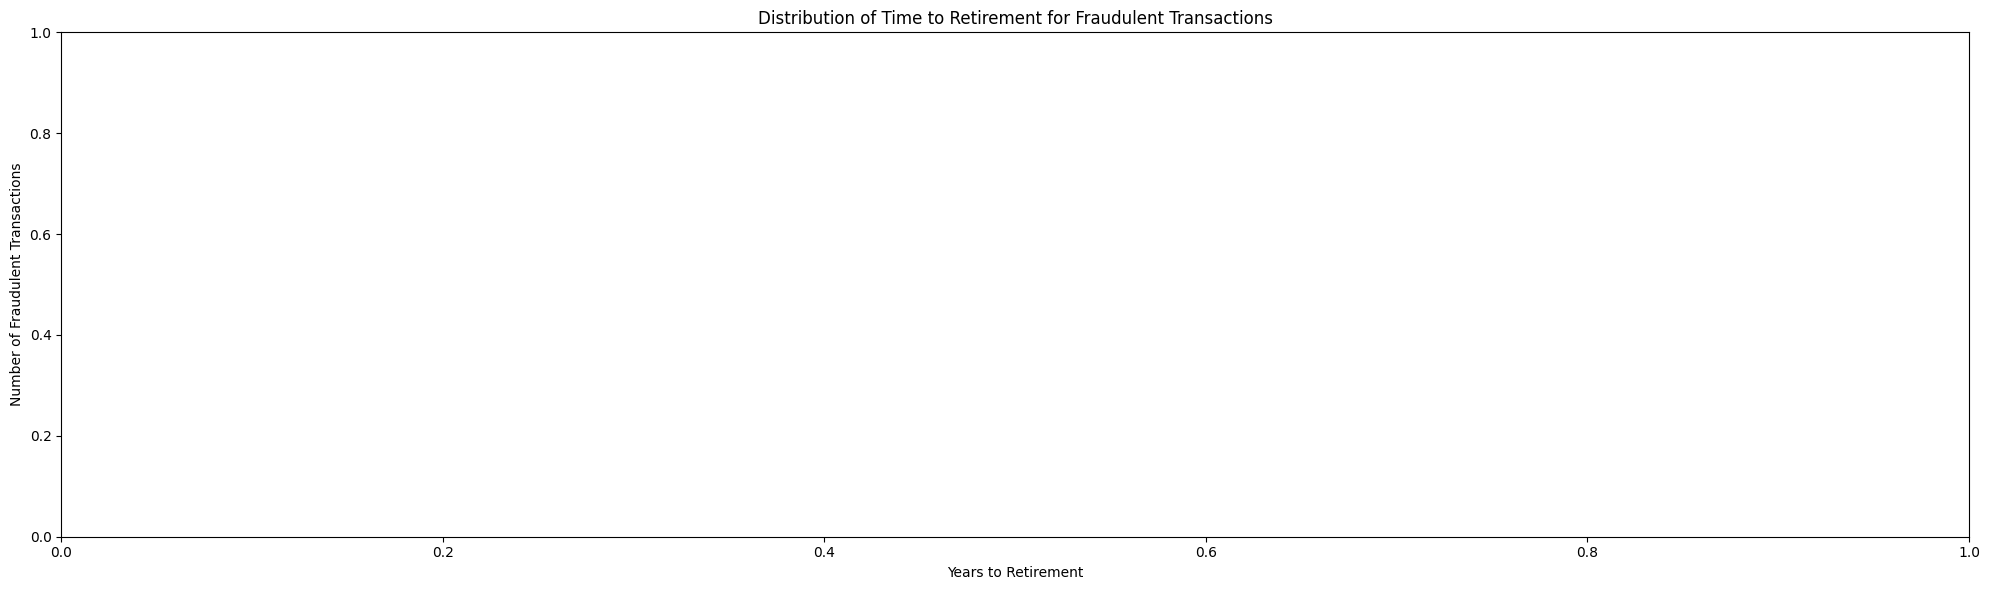

In [90]:
plt.figure(figsize=(20,6))
plt.title('Distribution of Time to Retirement for Fraudulent Transactions')
plt.xlabel('Years to Retirement')
plt.ylabel('Number of Fraudulent Transactions')
plt.tight_layout()
plt.show()

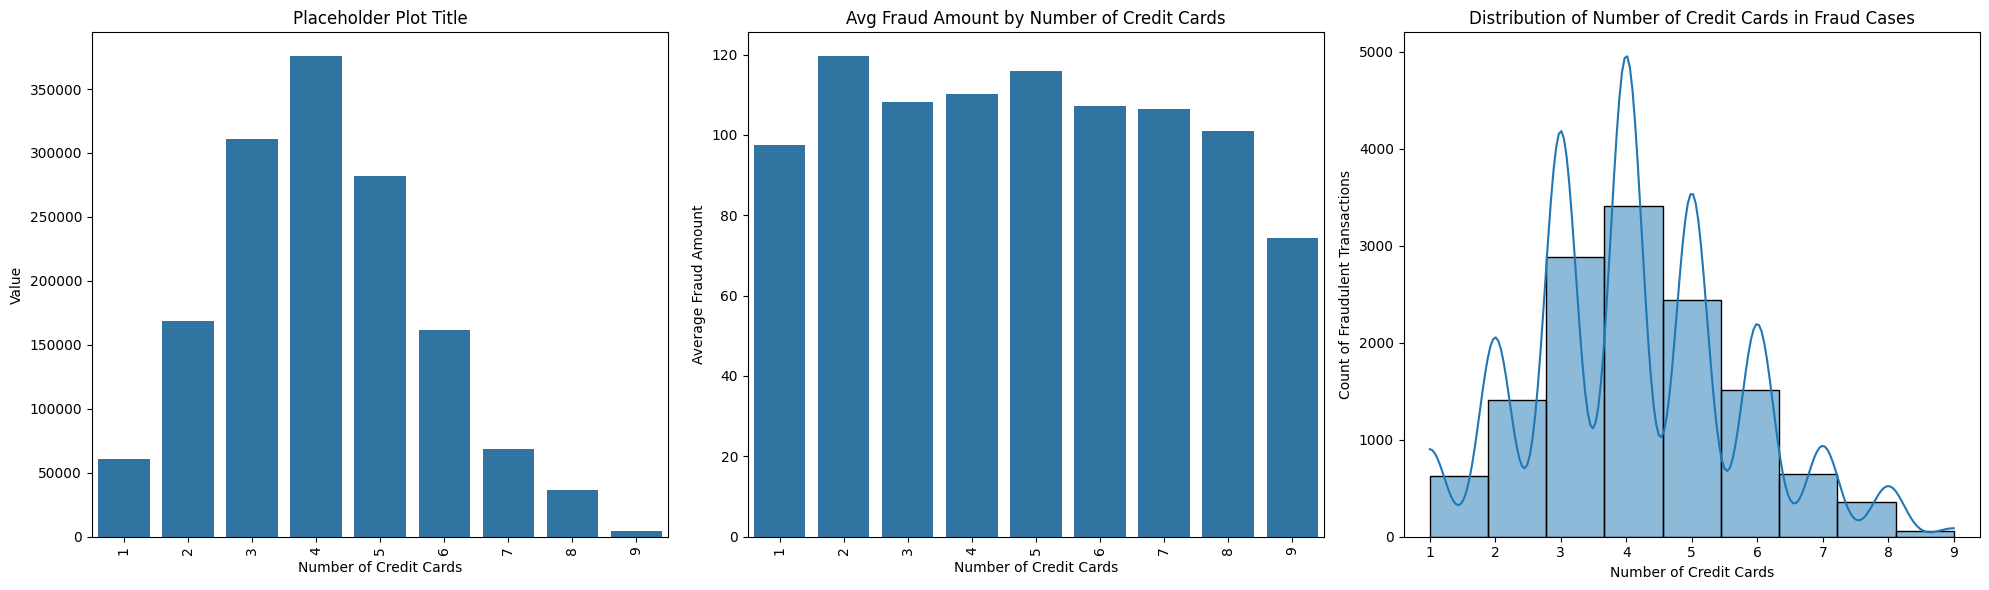

In [91]:
fig, ax = plt.subplots(1,3, figsize = (20,6))
sns.barplot(data=final_df[final_df.fraud==1][['num_credit_cards', 'amount']].groupby(['num_credit_cards']).sum(), x='num_credit_cards', y='amount',ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title('Placeholder Plot Title')  # Update this if ax[0] has a plot
ax[0].set_xlabel('Number of Credit Cards')
ax[0].set_ylabel('Value')

sns.barplot(data=final_df[final_df.fraud==1][['num_credit_cards', 'amount']].groupby(['num_credit_cards']).mean(), x='num_credit_cards', y='amount',ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title('Avg Fraud Amount by Number of Credit Cards')
ax[1].set_xlabel('Number of Credit Cards')
ax[1].set_ylabel('Average Fraud Amount')

sns.histplot(data=final_df[final_df.fraud==1], x='num_credit_cards', bins =9, kde=True, ax=ax[2])
ax[2].set_title('Distribution of Number of Credit Cards in Fraud Cases')
ax[2].set_xlabel('Number of Credit Cards')
ax[2].set_ylabel('Count of Fraudulent Transactions')

plt.tight_layout()
plt.show()

In [92]:
final_df[['num_credit_cards','debt_income_ratio','total_debt','yearly_income','fraud']].corr()

,num_credit_cards,debt_income_ratio,total_debt,yearly_income,fraud
num_credit_cards,1.000000,-0.240123,-0.204527,-0.039007,0.006799
debt_income_ratio,-0.240123,1.000000,0.782055,0.014058,-0.001794
total_debt,-0.204527,0.782055,1.000000,0.493097,-0.003213
yearly_income,-0.039007,0.014058,0.493097,1.000000,-0.003642
fraud,0.006799,-0.001794,-0.003213,-0.003642,1.000000


In [93]:
final_df['ones'] = 1

C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\1050656130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['ones'] = 1


In [94]:
final_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description,year,month,neg_amount,log_amount,day,day_name,is_weekend,day_type,hour,transaction_since_acct_open,transaction_before_expires,open_bin,expire_bin,debt_income_ratio,debt_bin,time_to_retirement,ones
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,7475327,0,Mastercard,Debit (Prepaid),2022-07-01,YES,2,55.0,2008-05-01,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores,2010,1,Yes,NaN,1,Friday,False,Weekday,0,1.667,12.500,"(1, 2]","(12.0, 13.0]",2.281687,"(2, 3]",37,1
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,7475328,0,Mastercard,Credit,2024-12-01,YES,1,9100.0,2005-09-01,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores,2010,1,No,2.745346,1,Friday,False,Weekday,0,4.333,14.917,"(4, 5]",NaN,3.042873,"(3, 4]",19,1
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,7475329,0,Mastercard,Debit,2020-05-01,YES,1,14802.0,2006-01-01,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer,2010,1,No,4.394449,1,Friday,False,Weekday,0,4.000,10.333,"(3, 4]","(10.0, 11.0]",1.060698,"(1, 2]",16,1
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,7475332,0,Visa,Debit,2020-01-01,YES,1,19113.0,2009-07-01,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages),2010,1,No,3.858833,1,Friday,False,Weekday,0,0.500,10.000,"(0, 1]","(9.0, 10.0]",1.406951,"(1, 2]",18,1
5,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464,5942,None,7475333,0,Mastercard,Debit (Prepaid),2014-03-01,YES,1,89.0,2008-01-01,2015,47,65,1972,12,Female,25537.0,52065.0,98613.0,828,5,Book Stores,2010,1,No,1.759581,1,Friday,False,Weekday,0,2.000,4.167,"(1, 2]","(4.0, 5.0]",1.894036,"(1, 2]",18,1


In [95]:
final_df['update_amt'] = np.where(final_df.neg_amount=='Yes',final_df['amount']*-1,final_df.amount)

C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\2070930057.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['update_amt'] = np.where(final_df.neg_amount=='Yes',final_df['amount']*-1,final_df.amount)


In [96]:
final_df['cumsum_user'] = final_df.groupby(['client_id']).update_amt.cumsum()
final_df['cumsum_card'] = final_df.groupby(['card_id']).update_amt.cumsum()
final_df['transaction_number_user'] = final_df.groupby(['client_id']).ones.cumsum()
final_df['transaction_number_card'] = final_df.groupby(['card_id']).ones.cumsum()

C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\1282399324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['cumsum_user'] = final_df.groupby(['client_id']).update_amt.cumsum()
C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\1282399324.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['cumsum_card'] = final_df.groupby(['card_id']).update_amt.cumsum()
C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\1282399324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [97]:
client_card_df = final_df[['client_id','card_id','fraud','update_amt']].groupby(['client_id','card_id','fraud']).agg(
        mean_amount=('update_amt', 'mean'),
        max_amount=('update_amt', 'max'),
        min_amount=('update_amt', 'min'),
        total_amount=('update_amt', 'sum'),
        count=('update_amt', 'count')
    ).reset_index()


In [98]:
client_card_df

,client_id,card_id,fraud,mean_amount,max_amount,min_amount,total_amount,count
0,0,1271,0,45.904068,577.46,0.65,212122.70,4621
1,0,1271,1,30.260000,45.48,15.04,60.52,2
2,0,4639,0,80.186643,1128.47,0.78,322270.12,4019
3,0,4639,1,70.697500,129.40,5.13,282.79,4
4,1,3682,0,39.487578,542.66,0.54,45331.74,1148
...,...,...,...,...,...,...,...,...
6125,1997,5808,1,23.900000,39.35,8.45,47.80,2
6126,1998,1258,0,46.078786,480.00,0.57,36448.32,791
6127,1998,2160,0,19.505712,109.42,0.59,27795.64,1425
6128,1998,2160,1,92.848000,297.45,0.75,464.24,5


In [99]:
client_card_df.head(10)

,client_id,card_id,fraud,mean_amount,max_amount,min_amount,total_amount,count
0,0,1271,0,45.904068,577.46,0.65,212122.70,4621
1,0,1271,1,30.260000,45.48,15.04,60.52,2
2,0,4639,0,80.186643,1128.47,0.78,322270.12,4019
3,0,4639,1,70.697500,129.40,5.13,282.79,4
4,1,3682,0,39.487578,542.66,0.54,45331.74,1148
5,1,4400,0,28.753644,634.41,0.27,59893.84,2083
6,1,4400,1,174.560000,286.39,2.20,523.68,3
7,1,4652,0,40.217440,937.15,0.58,141565.39,3520
8,1,4652,1,116.164000,367.00,9.04,1161.64,10
9,2,2576,0,30.642085,349.03,0.08,81722.44,2667


In [100]:
client_fraud_status = client_card_df.groupby('client_id')['fraud'].nunique()
single_clients = client_fraud_status[client_fraud_status == 1].index
fraud_only_clients = client_card_df[(client_card_df['client_id'].isin(single_clients)) & (client_card_df['fraud'] == 1)]['client_id'].unique()
fraud_only_clients


array([], dtype=int64)

In [101]:
no_fraud_only_clients = client_card_df[(client_card_df['client_id'].isin(single_clients)) & (client_card_df['fraud'] == 0)]['client_id'].unique()
no_fraud_only_clients


array([  57,   65,   87,  147,  170,  216,  432,  473,  628,  648,  660,
        747,  846,  895,  906, 1047, 1053, 1164, 1225, 1301, 1662, 1871,
       1874])

In [102]:
# Step 1: Aggregate fraud and total data
grouped = client_card_df.groupby(['client_id', 'card_id', 'fraud']).agg(
    fraud_count=('count', 'sum'),
    fraud_amount=('total_amount', 'sum')
).reset_index()

# Step 2: Pivot to get fraud and non-fraud side by side
pivoted = grouped.pivot(index=['client_id', 'card_id'], columns='fraud', values=['fraud_count', 'fraud_amount'])
pivoted.columns = ['count_nonfraud', 'count_fraud', 'amount_nonfraud', 'amount_fraud']
pivoted = pivoted.fillna(0).reset_index()

# Step 3: Calculate percentages
pivoted['fraud_count_pct'] = round(100 * pivoted['count_fraud'] / (pivoted['count_fraud'] + pivoted['count_nonfraud']),2)
pivoted['fraud_amount_pct'] = round(100 * pivoted['amount_fraud'] / (pivoted['amount_fraud'] + pivoted['amount_nonfraud']),2)


In [103]:
pivoted.sort_values('fraud_count_pct').tail(20)

,client_id,card_id,count_nonfraud,count_fraud,amount_nonfraud,amount_fraud,fraud_count_pct,fraud_amount_pct
1886,944,372,215.0,7.0,16559.83,302.10,3.15,1.79
1016,496,5806,744.0,25.0,55509.13,1953.57,3.25,3.40
3540,1746,3754,378.0,13.0,9137.06,5125.89,3.32,35.94
954,467,4481,140.0,5.0,4808.77,399.07,3.45,7.66
1553,764,1381,301.0,11.0,15931.26,518.41,3.53,3.15
1204,604,4280,281.0,11.0,5293.04,4386.14,3.77,45.32
1952,980,181,234.0,10.0,10426.70,982.01,4.10,8.61
2335,1176,2629,210.0,9.0,15160.67,1957.95,4.11,11.44
1524,754,2219,199.0,9.0,6271.47,680.40,4.33,9.79
2622,1302,3972,62.0,3.0,528.90,82.17,4.62,13.45


In [104]:
pivoted.sort_values('fraud_amount_pct').tail(20)

,client_id,card_id,count_nonfraud,count_fraud,amount_nonfraud,amount_fraud,fraud_count_pct,fraud_amount_pct
3428,1694,5032,1252.0,19.0,22950.16,2953.21,1.49,11.40
2335,1176,2629,210.0,9.0,15160.67,1957.95,4.11,11.44
1687,840,4992,264.0,5.0,8744.63,1199.46,1.86,12.06
3716,1833,2345,341.0,6.0,18923.75,2815.74,1.73,12.95
3939,1942,246,1607.0,5.0,8350.50,1254.38,0.31,13.06
2622,1302,3972,62.0,3.0,528.90,82.17,4.62,13.45
2024,1016,5883,501.0,8.0,9896.90,1992.37,1.57,16.76
3918,1928,2442,894.0,19.0,11905.08,2828.68,2.08,19.20
2981,1492,2171,560.0,9.0,4755.17,1461.11,1.58,23.50
2188,1102,3952,1413.0,37.0,20193.51,7097.85,2.55,26.01


In [105]:
def compute_risk_score(row):
    fraud_amt_threshold = pivoted[pivoted['fraud_count_pct']>0]['amount_fraud'].quantile(0.75)
    fraud_cnt_pct_threshold = pivoted[pivoted['fraud_count_pct']>0]['fraud_count_pct'].quantile(0.75)
    fraud_amt_pct_threshold = pivoted[pivoted['fraud_count_pct']>0]['fraud_amount_pct'].quantile(0.75)
    score = 0
    if row['fraud_count_pct'] > fraud_cnt_pct_threshold:
        score += 1
    if row['fraud_amount_pct'] > fraud_amt_pct_threshold:
        score += 1
    if row['amount_fraud'] > fraud_amt_threshold:
        score += 1
    return score

In [106]:
pivoted['risk_score'] = pivoted.apply(compute_risk_score, axis=1)

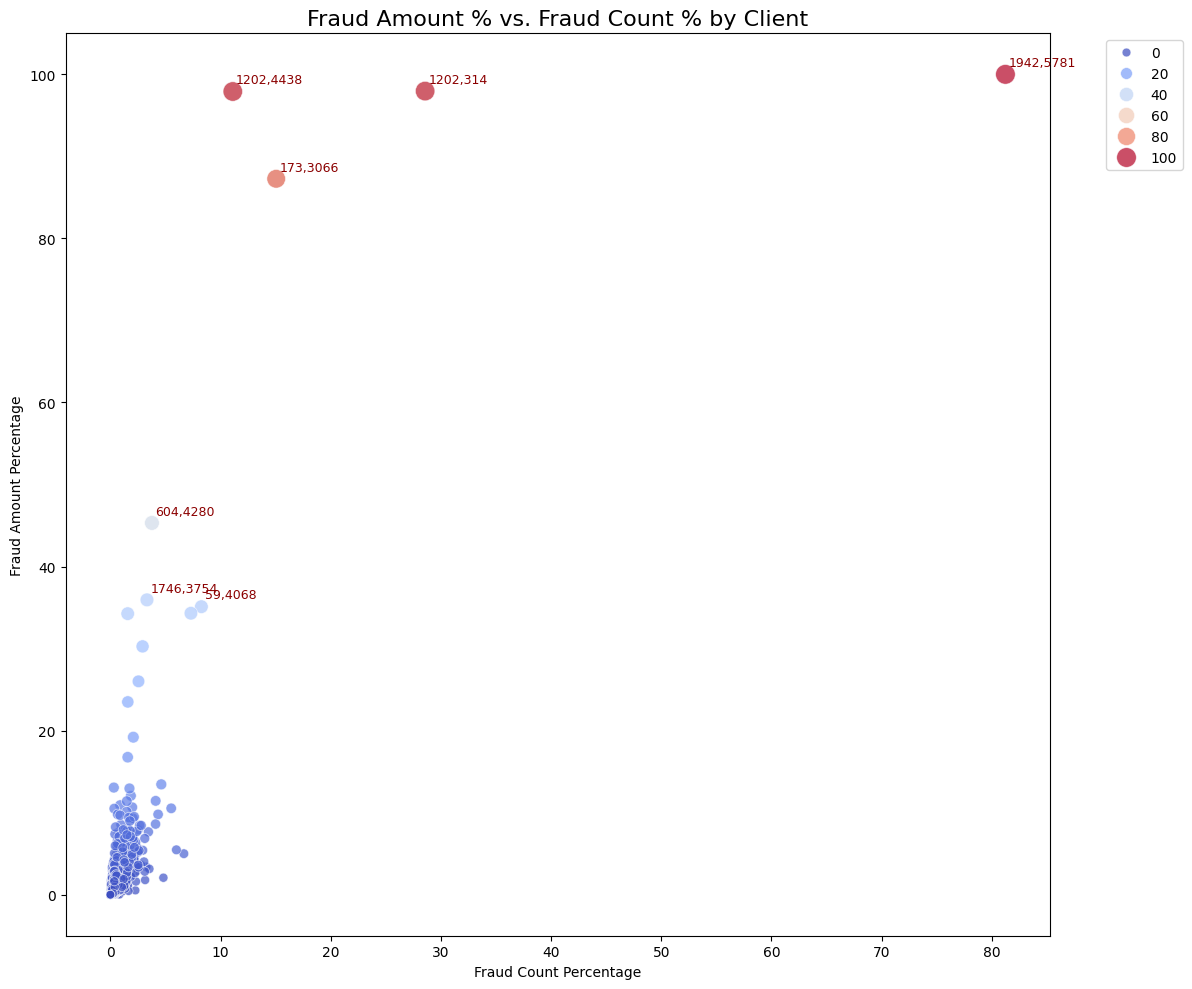

In [107]:
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot( data=pivoted, x="fraud_count_pct", y="fraud_amount_pct", hue="fraud_amount_pct", palette="coolwarm", size="fraud_amount_pct", sizes=(40, 200), alpha=0.7, edgecolor="w")

plt.title("Fraud Amount % vs. Fraud Count % by Client", fontsize=16)
plt.xlabel("Fraud Count Percentage")
plt.ylabel("Fraud Amount Percentage")

high_risk = pivoted[(pivoted["fraud_amount_pct"] > 35)]
for _, row in high_risk.iterrows():
    label = f"{int(row['client_id'])},{int(row['card_id'])}"
    plt.text(row["fraud_count_pct"] + 0.3, row["fraud_amount_pct"] + 1,
            label, fontsize=9, color='darkred')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()

In [108]:
final_df['fraud_trns_users'] = final_df.groupby(['client_id']).fraud.cumsum()
final_df['fraud_trns_card'] = final_df.groupby(['card_id']).fraud.cumsum()

C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\709424475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['fraud_trns_users'] = final_df.groupby(['client_id']).fraud.cumsum()
C:\Users\yashj\AppData\Local\Temp\ipykernel_16372\709424475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['fraud_trns_card'] = final_df.groupby(['card_id']).fraud.cumsum()


In [109]:
final_df.groupby('fraud')[['cumsum_user']].describe().reset_index()

fraud cumsum_user                                                 \
              count           mean            std   min        25%   
0     0   8901631.0  244656.569604  232434.719697   0.0  89388.020   
1     1     13332.0  201839.912414  191209.143174  38.7  69189.535   

                                        
          50%          75%         max  
0  186310.960  324609.0750  2393682.96  
1  166260.825  272804.4925  1961325.02

In [110]:
final_df.groupby('fraud')[['cumsum_card']].describe().reset_index()

fraud cumsum_card                                                            \
              count           mean            std   min         25%       50%   
0     0   8901631.0  104902.707283  134925.526807  0.00  26565.9750  63154.18   
1     1     13332.0   69717.457150   87924.197035  4.24  14886.0775  41745.87   

                            
           75%         max  
0  130848.8150  1761616.66  
1   88543.1025   912367.59

plots and analysis for above

In [111]:
final_df = final_df.merge(pivoted.rename(columns={'card_id': 'cc_id'})[['risk_score', 'cc_id']],how='left',left_on='card_id',right_on='cc_id')
final_df.drop('cc_id',inplace=True,axis =1)

In [112]:
final_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description,year,month,neg_amount,log_amount,day,day_name,is_weekend,day_type,hour,transaction_since_acct_open,transaction_before_expires,open_bin,expire_bin,debt_income_ratio,debt_bin,time_to_retirement,ones,update_amt,cumsum_user,cumsum_card,transaction_number_user,transaction_number_card,fraud_trns_users,fraud_trns_card,risk_score
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,7475327,0,Mastercard,Debit (Prepaid),2022-07-01,YES,2,55.0,2008-05-01,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores,2010,1,Yes,NaN,1,Friday,False,Weekday,0,1.667,12.500,"(1, 2]","(12.0, 13.0]",2.281687,"(2, 3]",37,1,77.00,77.00,77.00,1,1,0,0,3
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,7475328,0,Mastercard,Credit,2024-12-01,YES,1,9100.0,2005-09-01,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores,2010,1,No,2.745346,1,Friday,False,Weekday,0,4.333,14.917,"(4, 5]",NaN,3.042873,"(3, 4]",19,1,14.57,14.57,14.57,1,1,0,0,0
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,7475329,0,Mastercard,Debit,2020-05-01,YES,1,14802.0,2006-01-01,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer,2010,1,No,4.394449,1,Friday,False,Weekday,0,4.000,10.333,"(3, 4]","(10.0, 11.0]",1.060698,"(1, 2]",16,1,80.00,80.00,80.00,1,1,0,0,0
3,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,7475332,0,Visa,Debit,2020-01-01,YES,1,19113.0,2009-07-01,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages),2010,1,No,3.858833,1,Friday,False,Weekday,0,0.500,10.000,"(0, 1]","(9.0, 10.0]",1.406951,"(1, 2]",18,1,46.41,46.41,46.41,1,1,0,0,2
4,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464,5942,None,7475333,0,Mastercard,Debit (Prepaid),2014-03-01,YES,1,89.0,2008-01-01,2015,47,65,1972,12,Female,25537.0,52065.0,98613.0,828,5,Book Stores,2010,1,No,1.759581,1,Friday,False,Weekday,0,2.000,4.167,"(1, 2]","(4.0, 5.0]",1.894036,"(1, 2]",18,1,4.81,4.81,4.81,1,1,0,0,0


##### Converting objects to integers

In [114]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [115]:
final_df['card_brand']= label_encoder.fit_transform(final_df['card_brand'])
final_df['card_type']= label_encoder.fit_transform(final_df['card_type'])
final_df['transaction_mode']= label_encoder.fit_transform(final_df['transaction_mode'])
final_df['has_chip']= label_encoder.fit_transform(final_df['has_chip'])


In [116]:
final_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description,year,month,neg_amount,log_amount,day,day_name,is_weekend,day_type,hour,transaction_since_acct_open,transaction_before_expires,open_bin,expire_bin,debt_income_ratio,debt_bin,time_to_retirement,ones,update_amt,cumsum_user,cumsum_card,transaction_number_user,transaction_number_card,fraud_trns_users,fraud_trns_card,risk_score
0,2010-01-01 00:01:00,1556,2972,-77.00,2,59935,Beulah,ND,58523,5499,None,7475327,0,2,2,2022-07-01,1,2,55.0,2008-05-01,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores,2010,1,Yes,NaN,1,Friday,False,Weekday,0,1.667,12.500,"(1, 2]","(12.0, 13.0]",2.281687,"(2, 3]",37,1,77.00,77.00,77.00,1,1,0,0,3
1,2010-01-01 00:02:00,561,4575,14.57,2,67570,Bettendorf,IA,52722,5311,None,7475328,0,2,0,2024-12-01,1,1,9100.0,2005-09-01,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores,2010,1,No,2.745346,1,Friday,False,Weekday,0,4.333,14.917,"(4, 5]",NaN,3.042873,"(3, 4]",19,1,14.57,14.57,14.57,1,1,0,0,0
2,2010-01-01 00:02:00,1129,102,80.00,2,27092,Vista,CA,92084,4829,None,7475329,0,2,1,2020-05-01,1,1,14802.0,2006-01-01,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer,2010,1,No,4.394449,1,Friday,False,Weekday,0,4.000,10.333,"(3, 4]","(10.0, 11.0]",1.060698,"(1, 2]",16,1,80.00,80.00,80.00,1,1,0,0,0
3,2010-01-01 00:06:00,848,3915,46.41,2,13051,Harwood,MD,20776,5813,None,7475332,0,3,1,2020-01-01,1,1,19113.0,2009-07-01,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages),2010,1,No,3.858833,1,Friday,False,Weekday,0,0.500,10.000,"(0, 1]","(9.0, 10.0]",1.406951,"(1, 2]",18,1,46.41,46.41,46.41,1,1,0,0,2
4,2010-01-01 00:07:00,1807,165,4.81,2,20519,Bronx,NY,10464,5942,None,7475333,0,2,2,2014-03-01,1,1,89.0,2008-01-01,2015,47,65,1972,12,Female,25537.0,52065.0,98613.0,828,5,Book Stores,2010,1,No,1.759581,1,Friday,False,Weekday,0,2.000,4.167,"(1, 2]","(4.0, 5.0]",1.894036,"(1, 2]",18,1,4.81,4.81,4.81,1,1,0,0,0


In [117]:
final_df[['merchant_id','merchant_city','merchant_state','Description']].nunique()

merchant_id       66537
merchant_city     12173
merchant_state      199
Description         108
dtype: int64

In [118]:
final_df['merchant_state']= label_encoder.fit_transform(final_df['merchant_state'])
final_df['merchant_city']= label_encoder.fit_transform(final_df['merchant_city'])
final_df['Description']= label_encoder.fit_transform(final_df['Description'])
final_df['gender']= label_encoder.fit_transform(final_df['gender'])
final_df['error']= label_encoder.fit_transform(final_df['error'])
final_df['zip']= label_encoder.fit_transform(final_df['zip'])
final_df['open_bin']= label_encoder.fit_transform(final_df['open_bin'])
final_df['expire_bin']= label_encoder.fit_transform(final_df['expire_bin'])
final_df['debt_bin']= label_encoder.fit_transform(final_df['debt_bin'])
final_df['day_name']= label_encoder.fit_transform(final_df['day_name'])
final_df['is_weekend']= label_encoder.fit_transform(final_df['is_weekend'])


In [119]:
final_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description,year,month,neg_amount,log_amount,day,day_name,is_weekend,day_type,hour,transaction_since_acct_open,transaction_before_expires,open_bin,expire_bin,debt_income_ratio,debt_bin,time_to_retirement,ones,update_amt,cumsum_user,cumsum_card,transaction_number_user,transaction_number_card,fraud_trns_users,fraud_trns_card,risk_score
0,2010-01-01 00:01:00,1556,2972,-77.00,2,59935,817,117,14273,5499,22,7475327,0,2,2,2022-07-01,1,2,55.0,2008-05-01,2008,30,67,1989,7,0,23679.0,48277.0,110153.0,740,4,64,2010,1,Yes,NaN,1,0,0,Weekday,0,1.667,12.500,1,12,2.281687,2,37,1,77.00,77.00,77.00,1,1,0,0,3
1,2010-01-01 00:02:00,561,4575,14.57,2,67570,816,67,12834,5311,22,7475328,0,2,0,2024-12-01,1,1,9100.0,2005-09-01,2015,48,67,1971,6,1,18076.0,36853.0,112139.0,834,5,26,2010,1,No,2.745346,1,0,0,Weekday,0,4.333,14.917,4,14,3.042873,3,19,1,14.57,14.57,14.57,1,1,0,0,0
2,2010-01-01 00:02:00,1129,102,80.00,2,27092,11332,24,22319,4829,22,7475329,0,2,1,2020-05-01,1,1,14802.0,2006-01-01,2008,49,65,1970,4,1,16894.0,34449.0,36540.0,686,3,70,2010,1,No,4.394449,1,0,0,Weekday,0,4.000,10.333,3,10,1.060698,1,16,1,80.00,80.00,80.00,1,1,0,0,0
3,2010-01-01 00:06:00,848,3915,46.41,2,13051,4595,94,3143,5813,22,7475332,0,3,1,2020-01-01,1,1,19113.0,2009-07-01,2014,51,69,1968,5,1,33529.0,68362.0,96182.0,711,2,32,2010,1,No,3.858833,1,0,0,Weekday,0,0.500,10.000,0,9,1.406951,1,18,1,46.41,46.41,46.41,1,1,0,0,2
4,2010-01-01 00:07:00,1807,165,4.81,2,20519,1226,123,125,5942,22,7475333,0,2,2,2014-03-01,1,1,89.0,2008-01-01,2015,47,65,1972,12,0,25537.0,52065.0,98613.0,828,5,12,2010,1,No,1.759581,1,0,0,Weekday,0,2.000,4.167,1,4,1.894036,1,18,1,4.81,4.81,4.81,1,1,0,0,0


##### Correlation Matrix

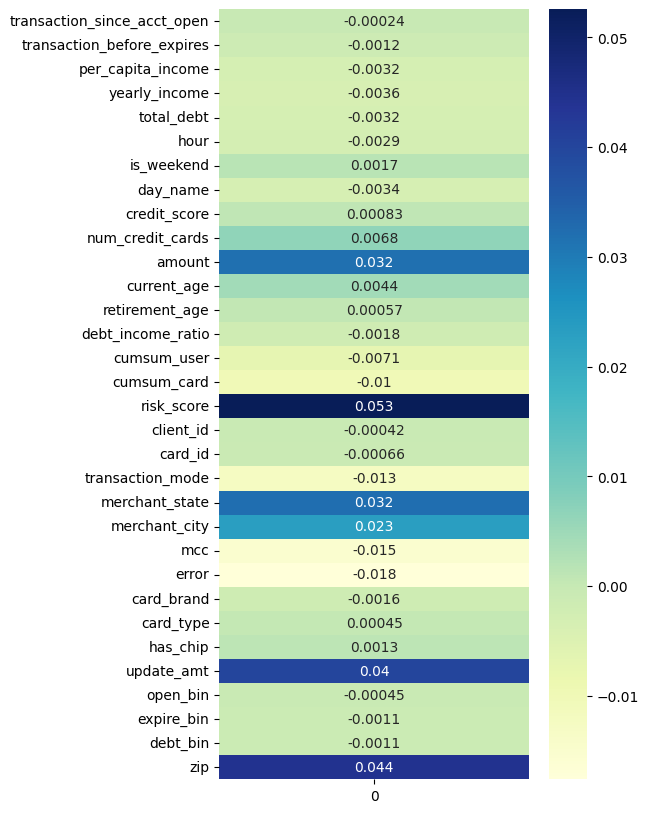

In [120]:

co_mtx = final_df[['transaction_since_acct_open','transaction_before_expires','per_capita_income','yearly_income','total_debt','hour','is_weekend','day_name',
                    'credit_score','num_credit_cards','amount','current_age','retirement_age','debt_income_ratio','cumsum_user','cumsum_card','risk_score',
                'client_id','card_id','transaction_mode','merchant_state','merchant_city','mcc','error','card_brand','card_type','has_chip','update_amt','open_bin','expire_bin','debt_bin','zip']].corrwith(final_df.fraud)

fig, ax = plt.subplots(figsize=(5,10))
sns.heatmap(pd.DataFrame(co_mtx),annot = True,cmap="YlGnBu")
plt.show()

In [121]:
round(co_mtx,3).sort_values()

error                         -0.018
mcc                           -0.015
transaction_mode              -0.013
cumsum_card                   -0.010
cumsum_user                   -0.007
yearly_income                 -0.004
day_name                      -0.003
per_capita_income             -0.003
hour                          -0.003
total_debt                    -0.003
card_brand                    -0.002
debt_income_ratio             -0.002
transaction_before_expires    -0.001
card_id                       -0.001
debt_bin                      -0.001
expire_bin                    -0.001
open_bin                      -0.000
card_type                      0.000
transaction_since_acct_open   -0.000
client_id                     -0.000
credit_score                   0.001
retirement_age                 0.001
has_chip                       0.001
is_weekend                     0.002
current_age                    0.004
num_credit_cards               0.007
merchant_city                  0.023
a

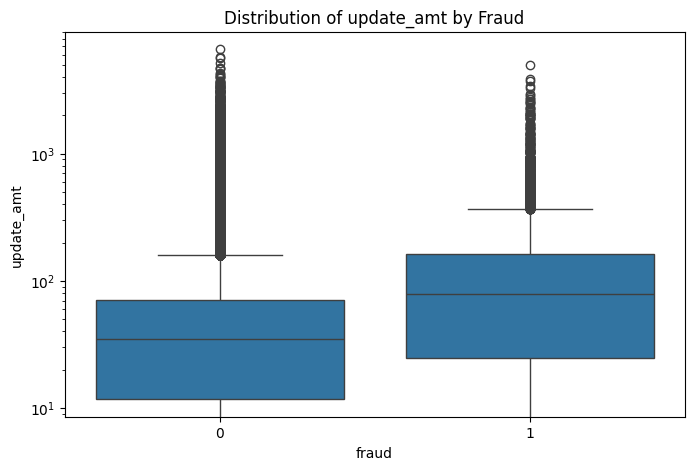

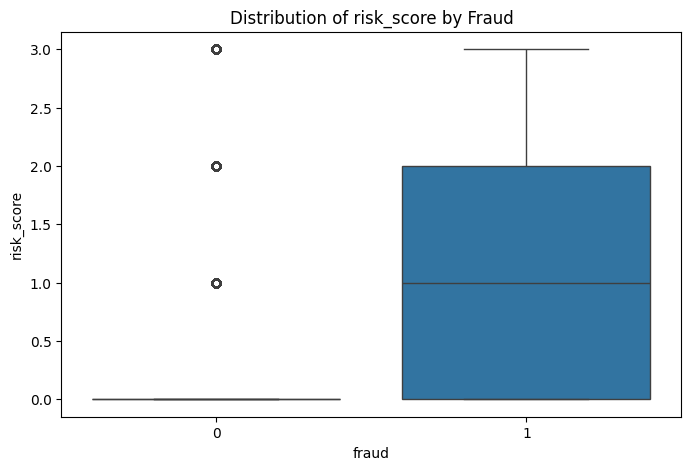

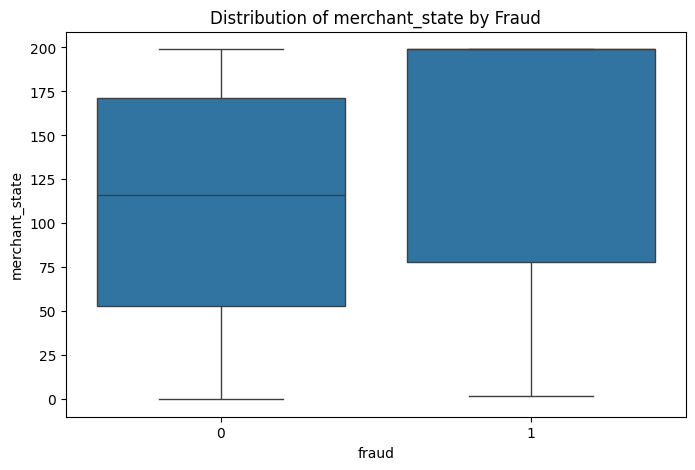

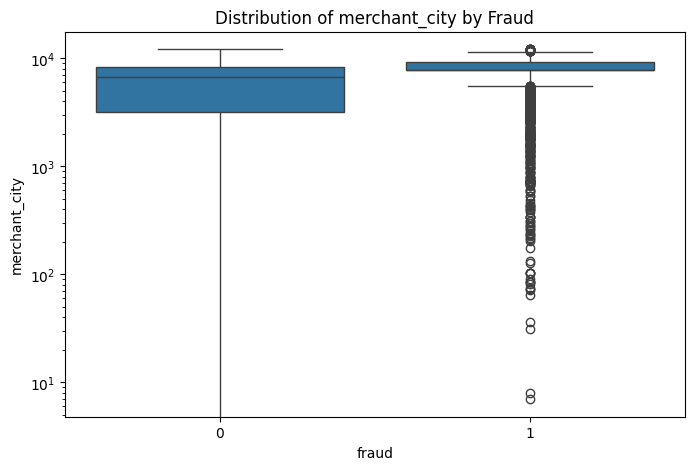

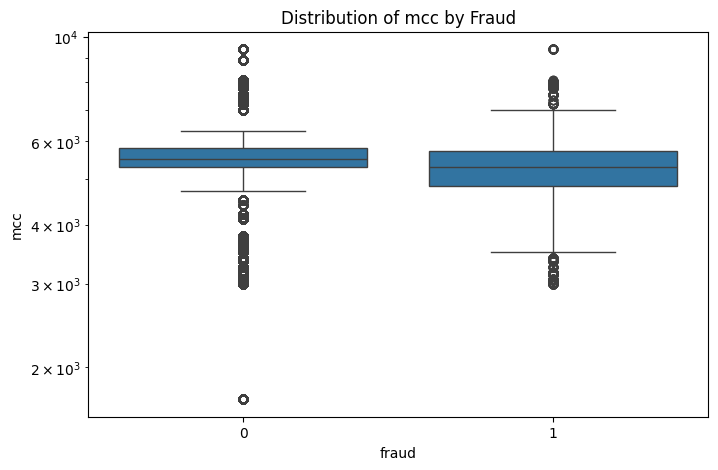

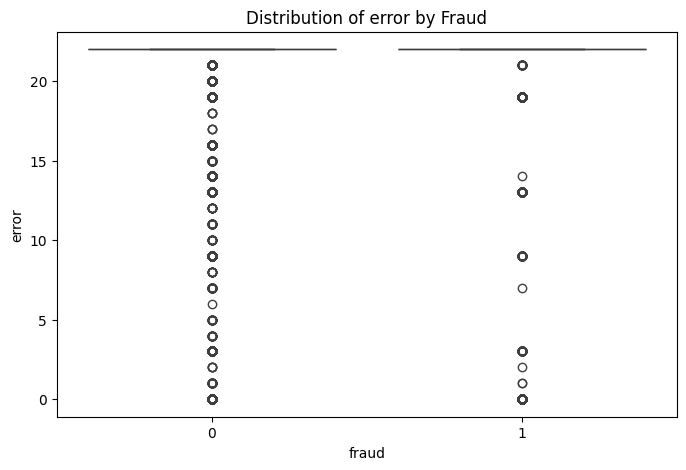

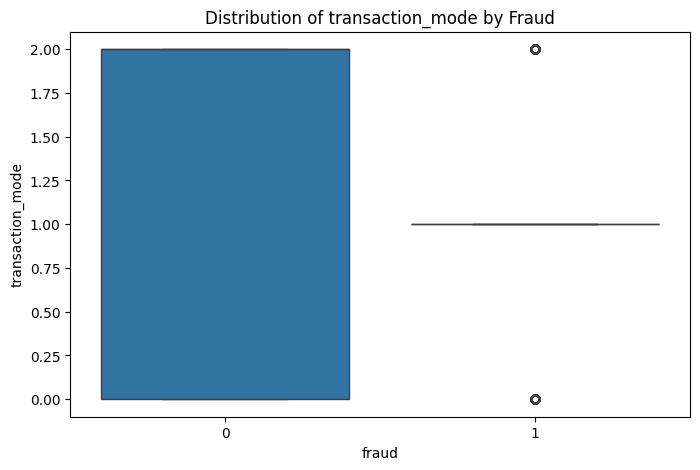

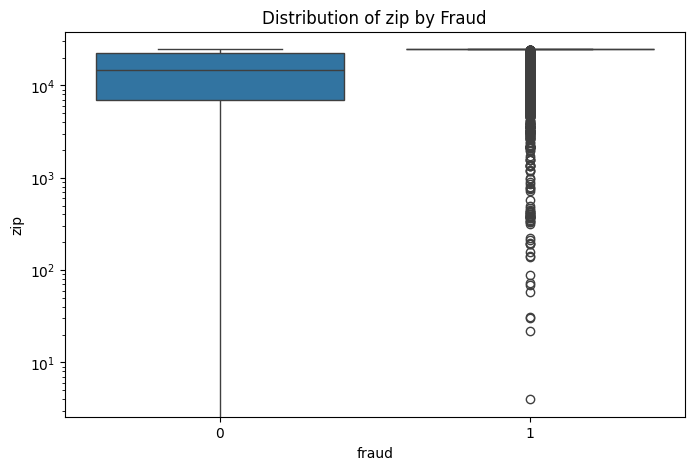

In [122]:
features = ['update_amt', 'risk_score', 'merchant_state', 'merchant_city', 'mcc','error', 'transaction_mode','zip']
for feature in features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=final_df, x='fraud', y=feature)
    plt.title(f'Distribution of {feature} by Fraud')
    plt.yscale('log') if final_df[feature].max() > 1000 else None
    plt.show()


In [123]:
final_df[['hour','is_weekend','day_name']].corrwith(final_df.fraud)

hour         -0.002899
is_weekend    0.001744
day_name     -0.003400
dtype: float64

In [124]:
final_df[['gender']].corrwith(final_df.fraud)

gender   -0.000882
dtype: float64

In [125]:
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,transaction_id,fraud,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_year,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,Description,year,month
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,7475327.0,No,Mastercard,Debit (Prepaid),07/2022,YES,2,55.0,05/2008,2008,30,67,1989,7,Female,23679.0,48277.0,110153.0,740,4,Miscellaneous Food Stores,2010,1
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,7475328.0,No,Mastercard,Credit,12/2024,YES,1,9100.0,09/2005,2015,48,67,1971,6,Male,18076.0,36853.0,112139.0,834,5,Department Stores,2010,1
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,7475329.0,No,Mastercard,Debit,05/2020,YES,1,14802.0,01/2006,2008,49,65,1970,4,Male,16894.0,34449.0,36540.0,686,3,Money Transfer,2010,1
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None,NaN,NaN,Mastercard,Debit,10/2024,NO,2,37634.0,05/2004,2006,52,67,1967,5,Female,26168.0,53350.0,128676.0,685,5,Money Transfer,2010,1
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,7475332.0,No,Visa,Debit,01/2020,YES,1,19113.0,07/2009,2014,51,69,1968,5,Male,33529.0,68362.0,96182.0,711,2,Drinking Places (Alcoholic Beverages),2010,1


In [126]:
columns = ['amount', 'merchant_state', 'merchant_city', 'mcc','error', 'transaction_mode','zip','card_id','has_chip','card_type','card_brand','fraud']

In [127]:
main_df = main_df[columns]